# Finding accreted stars in the Milky Way: clues from NIHAO simulations

#### Authors:  
Luka Mijnarends (u6956623@anu.edu.au),  
Sven Buder (sven.buder@anu.edu.au),  
Tobias Buck

In [27]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import glob
import scipy
import os
import pandas
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
import astropy.io.fits as pyfits
from astropy.table import Table, hstack, vstack, join
from astropy.io import fits
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

# Part 1: Prepare Data

## 1a) Read in the data from GALAH+ DR3.  
We already have cross-matched the main catalog and the value-added catalogs via sobject_id.  
The catalog data is provided at https://datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/   
The analysis is described by Buder et al. (2022): https://ui.adsabs.harvard.edu/abs/2021MNRAS.506..150B.  

In [4]:
try:
    obs = Table.read('GALAH_DR3_all_joined_v2.fits')
    print('Read in joined file of main_allstar, VAC_ages, and VAC_dynamics.')
except:
    print('Could not read in joined file. Reading in and joining main_allstar, VAC_ages, and VAC_dynamics.')

    allstar = Table.read('GALAH_DR3_main_allstar_v2.fits')
    ages = Table.read('GALAH_DR3_VAC_ages_v2.fits')
    dyn = Table.read('GALAH_DR3_VAC_dynamics_v2.fits')
    files = join(allstar, dyn, keys = 'sobject_id',metadata_conflicts='silent')

    obs = join(files, ages, keys = 'sobject_id',metadata_conflicts='silent')
    
    obs.write('GALAH_DR3_all_joined_v2.fits',overwrite=True)

Read in joined file of main_allstar, VAC_ages, and VAC_dynamics.


In [5]:
# Let's apply some basic cuts that allows us to continue with a roughly cleaned set of stars
observation_quality_check_default = (
    (obs['flag_repeat']==0) & # Make sure we only have 1 measurement per star
    (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
    (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
    (obs['snr_c2_iraf'] > 25) & # SNR above 25 to get reasonable stellar parameters
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg']],axis=0)[0] # flags for all abundances measurements should be unflagged, here only Mg is tested
)
obs = obs[observation_quality_check_default]

## 1b) Read in the simulation
The simulation is part of the NIHAO suite.  
This particular simulation can be retrieved from Tobias Buck.  
It is described in detail in Buck et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3365B

In [89]:
fits_file = fits.open('NIHAO_g8.26e11_simulation_data_220118.fits')
sim = fits_file[1].data
fits_file.close()

r_solar = 8.2 # kpc similar to solar radius
radius = 4.2 # kpc radius similar to GALAH's 95th distance percentile

# Sphere around R=8kpc with radius of e.g. 1 kpc:
# sqrt((R-8)**2 + Z**2) < 1 kpc
sim_solar = (
    (np.sqrt((np.sqrt(sim['X']**2 + sim['Y']**2) - r_solar)**2 + sim['Z']**2) < radius)
)
sim_solar_b10deg = sim_solar & (np.tan(10*np.pi/180) < abs(sim['Z']) / abs(np.sqrt(sim['X']**2 + sim['Y']**2) - r_solar))

what_shall_we_use = 'solar_circle_b10deg'

sim_all = sim

if what_shall_we_use == 'solar_circle':
    sim = sim[sim_solar]
elif what_shall_we_use == 'solar_circle_b10deg':
    sim = sim[sim_solar_b10deg]

# Part 2: Overview of the abundances in observation and simulations

The simulation traces the chemical evolution of the following elements:  
H, He, C, N, O, Ne, Mg, Al, Si, P, S, V, Cr, Mn, Fe, Co, Ba.  

Of these, the following ten are also reported by the GALAH survey:  
C, O, Mg, Al, Si, V, Cr, Mn, Co and Ba

Caption: Distribution of elemental abundances [X/Fe] versus [Fe/H] for the ten elements overlapping between GALAH and NIHAO. Observations are shown in first and third row with simulated distributions in the row next to them. Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities. For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. Dashed lines indicate Solar values.


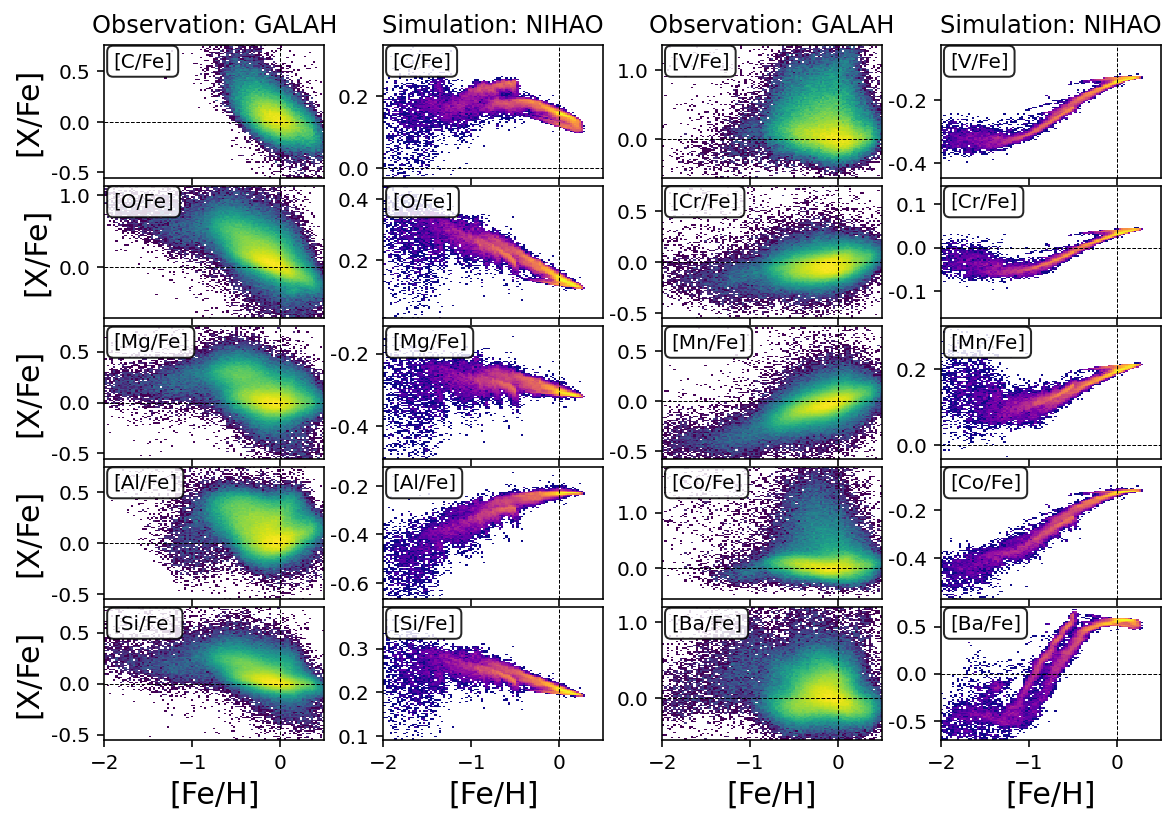

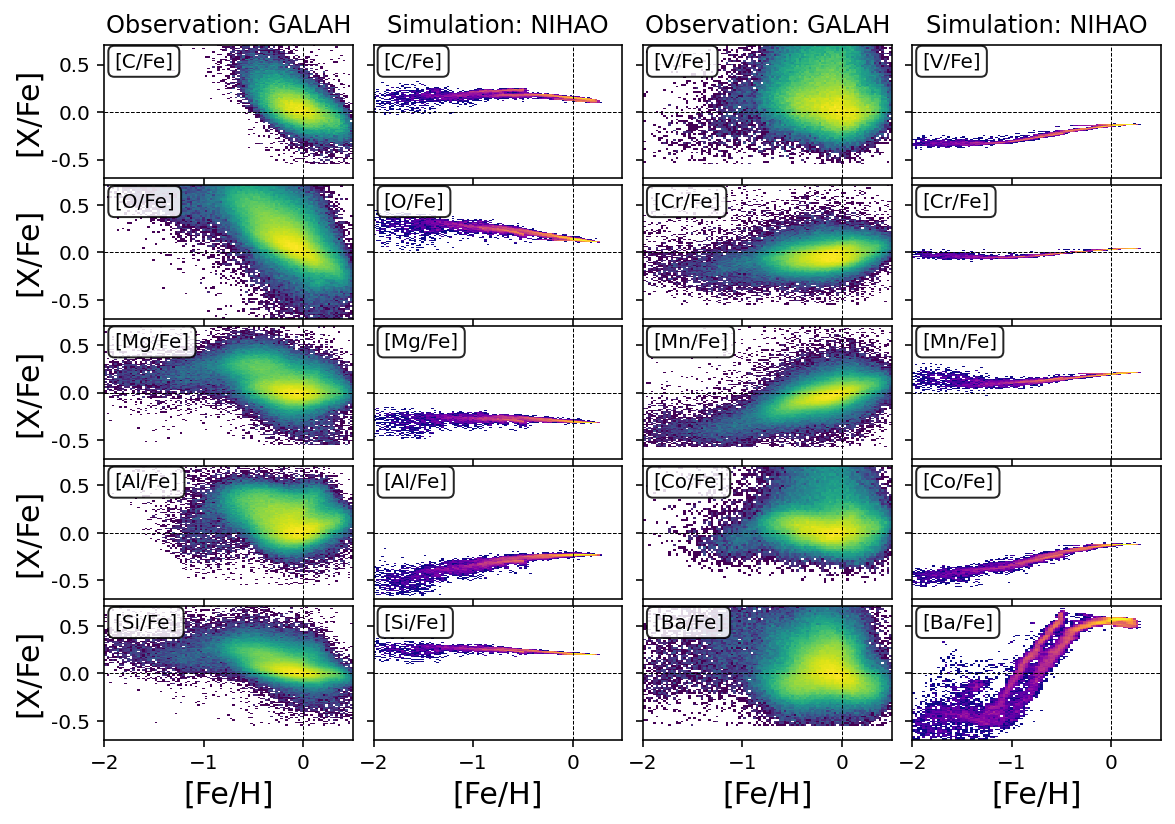

In [91]:
# Let's plot an overview of all these 10 elements:

def plot_abundance_overview_observations_simulations(sim, sharey=False):
    """
    Distribution of elemental abundances [X/Fe] versus [Fe/H] 
    for the ten elements overlapping between GALAH and NIHAO.
    
    Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities.
    For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. 
    Dashed lines indicate Solar values.
    
    INPUT:
    sharey = False/True: Shall the abundances [X/Fe] be plotted on the same y-axis range?
    
    OUTPUT:
    plt.savefig() with or without shary
    
    """

    f, gs = plt.subplots(5,4,sharex=True,sharey=sharey,figsize=(8.27, 11.69/2.))

    for element_index, element in enumerate(['C','O','Mg','Al','Si','V','Cr','Mn','Co','Ba']):

        # For better visibility, we limit ourselves to [Fe/H] > -2 in both observations and simulations
        fe_h_lower_limit = -2
        
        # Observations are shown in first and third row with simulated distributions in the row next to them. 
        if element_index <= 4:
            ax_obs = gs[element_index,0]
            ax_sim = gs[element_index,1]
        else:
            ax_obs = gs[element_index-5,2]
            ax_sim = gs[element_index-5,3]
            
        ax_obs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax_sim.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        ######
        # Panels with observations
        ######
        
        # We apply our usual quality checks, but here for each element individually
        observation_quality_check = (
            (obs['flag_'+element+'_fe'] == 0) &
            (obs['fe_h'] >= fe_h_lower_limit)
        )
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex (but at least -0.55 and 0.75)
        xfe_obs = obs[element+'_fe'][observation_quality_check]
        percentiles_obs = np.percentile(xfe_obs,q=[0.5,99.5])
        ax_obs.hist2d(
            obs['fe_h'][observation_quality_check],
            obs[element+'_fe'][observation_quality_check],
            bins=(np.linspace(fe_h_lower_limit,0.5,100),np.linspace(np.min([-0.55,percentiles_obs[0]-0.1]),np.max([0.75,percentiles_obs[-1]+0.1]),100)),
            cmin = 1,
            norm = LogNorm()
        )
        
        ######
        # Panels with simulations
        ######
        
        simulation_hack = (
            (sim['Fe_H'] > fe_h_lower_limit) # This is just to make sure that the plot ranges do not explode...
        )
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex
        sim_xfe = sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack]
        percentiles_sim = np.percentile(sim_xfe,q=[0.5,99.5])
        
        ax_sim.hist2d(
            sim['Fe_H'][simulation_hack],
            sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack],
            bins=(np.linspace(fe_h_lower_limit,0.5,100),np.linspace(percentiles_sim[0]-0.1,percentiles_sim[-1]+0.1,100)),
            cmin = 1,
            norm = LogNorm(),
            cmap = 'plasma'
        )

        # Add text with [X/Fe]
        ax_obs.text(0.04,0.95,'['+element+'/Fe]',transform=ax_obs.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax_sim.text(0.04,0.95,'['+element+'/Fe]',transform=ax_sim.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

        # Add Solar value lines at (0,0)
        ax_obs.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_obs.axvline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axvline(0,lw=0.5,ls='dashed',c='k')
        
        # Add titles and x-/y-labels
        if element_index in [0,5]:
            ax_obs.set_title('Observation: GALAH')
            ax_sim.set_title('Simulation: NIHAO')
        if element_index in [4,9]:
            ax_obs.set_xlabel('[Fe/H]')
            ax_sim.set_xlabel('[Fe/H]')
        if element_index <= 4:        
            ax_obs.set_ylabel('[X/Fe]')
   
    plt.tight_layout(h_pad=0,w_pad=0.3)
#     if sharey:
#         plt.savefig('figures/Overview_FeH_XFe_Obs_Sim_sharey.png',bbox_inches='tight',dpi=200)
#     else:
#         plt.savefig('figures/Overview_FeH_XFe_Obs_Sim.png',bbox_inches='tight',dpi=200)

plot_abundance_overview_observations_simulations(sim, sharey=False)
plot_abundance_overview_observations_simulations(sim, sharey=True)

print('Caption: Distribution of elemental abundances [X/Fe] versus [Fe/H] for the ten elements overlapping between GALAH and NIHAO. Observations are shown in first and third row with simulated distributions in the row next to them. Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities. For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. Dashed lines indicate Solar values.')

# Part 3: A closer look at the 'low-alpha halo'

Inspired by Nissen et al. (2010), here we plot different populations in the metal-poor low-/high-alpha halo regime, and observe how overdensities appear in different abundance planes. 

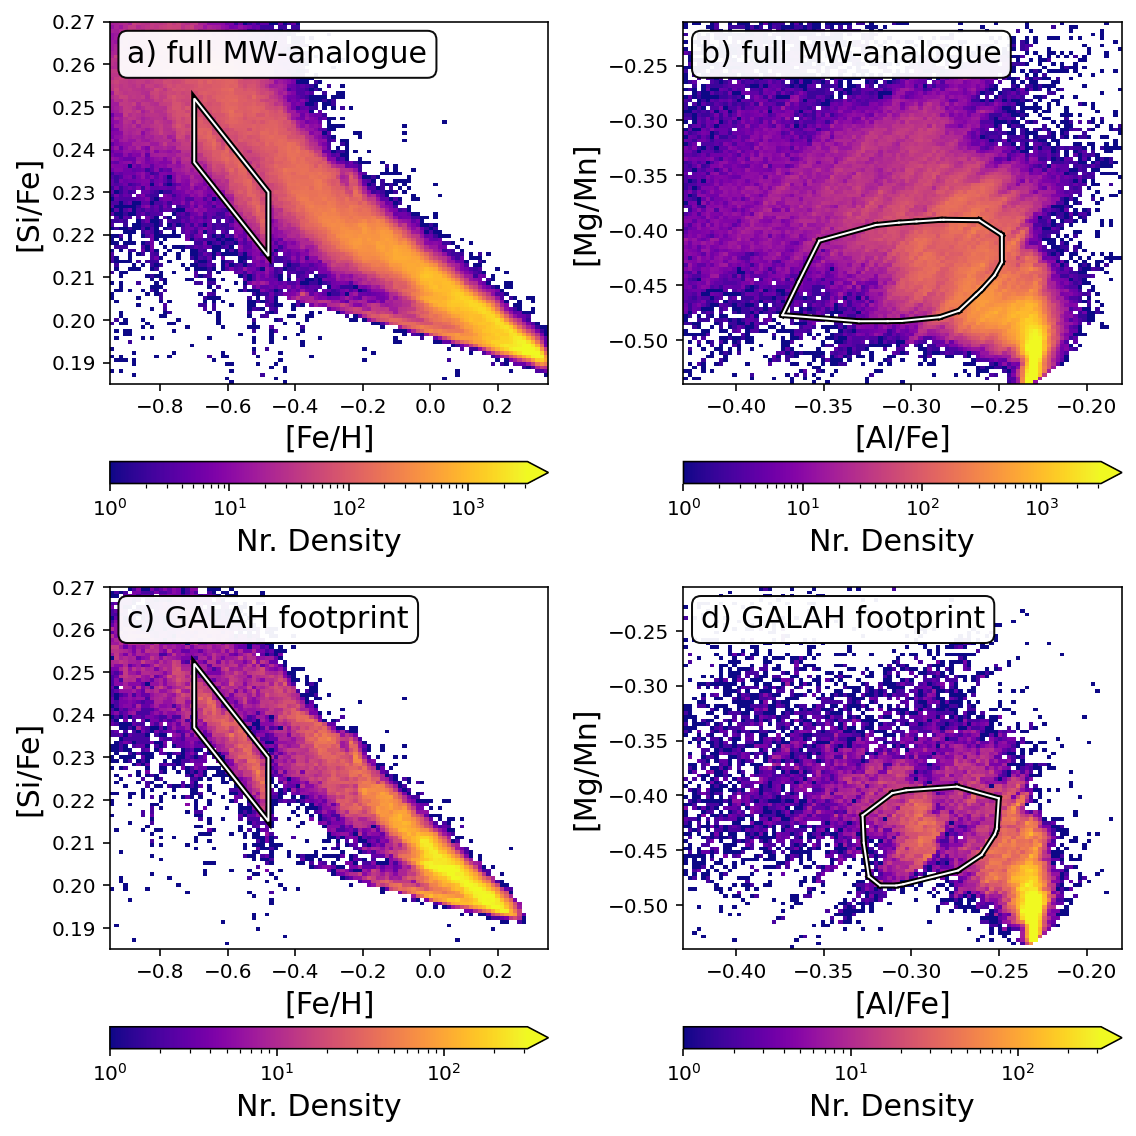

In [113]:
def plot_low_alpha_halo():
    
    panels = ['a)','b)','c)','d)']
    
    f, gs = plt.subplots(2,2,figsize=(8,8))
    
    for sim_index, sim_i in enumerate([sim_all, sim]):
    
        if sim_index == 0:
            sim_label = ' full MW-analogue'
        else:
            sim_label = ' GALAH footprint'
    
        if sim_index == 0:
            vmax = 10**3.5
        else:
            vmax = 10**2.5
    
        lower_feh_limit = -0.7
        upper_feh_limit = -0.48
        slope = -0.1
        intercept1 = 0.167
        intercept2 = 0.182

        select_low_alpha_halo = (
            (sim_i['Fe_H'] > lower_feh_limit) &
            (sim_i['Fe_H'] < upper_feh_limit) &
            (sim_i['Si_H'] - sim_i['Fe_H'] > intercept1 + slope*sim_i['Fe_H']) &
            (sim_i['Si_H'] - sim_i['Fe_H'] < intercept2 + slope*sim_i['Fe_H'])
        )

        ax = gs[sim_index,0]
        ax.text(0.04,0.95,panels[0+2*sim_index]+sim_label,fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        p = ax.hist2d(
            sim_i['Fe_H'],
            sim_i['Si_H'] - sim_i['Fe_H'],
            bins = (np.linspace(-0.95,0.35,100),np.linspace(0.185,0.27,100)),
            cmin = 1, cmap='plasma',
            norm = LogNorm(vmin = 1, vmax = vmax)
        )
        c = plt.colorbar(p[-1],ax=ax,extend='max',orientation='horizontal')
        c.set_label('Nr. Density')

        polygon = Polygon(
            [
                [lower_feh_limit,intercept1 + slope*lower_feh_limit],
                [upper_feh_limit,intercept1 + slope*upper_feh_limit],
                [upper_feh_limit,intercept2 + slope*upper_feh_limit],
                [lower_feh_limit,intercept2 + slope*lower_feh_limit]
            ], 
            True,
            fill=False,
            edgecolor = 'k',
            lw = 3
        )
        ax.add_patch(polygon)
        polygon = Polygon(
            [
                [lower_feh_limit,intercept1 + slope*lower_feh_limit],
                [upper_feh_limit,intercept1 + slope*upper_feh_limit],
                [upper_feh_limit,intercept2 + slope*upper_feh_limit],
                [lower_feh_limit,intercept2 + slope*lower_feh_limit]
            ], 
            True,
            fill=False,
            edgecolor = 'w',
            lw = 1
        )
        ax.add_patch(polygon)


        ax.set_xlabel('[Fe/H]')
        ax.set_ylabel('[Si/Fe]')

        # [Al/Fe] vs. [Mg/Mn]
        ax = gs[sim_index,1]
        ax.text(0.04,0.95,panels[1+2*sim_index]+sim_label,fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        p = ax.hist2d(
            sim_i['Al_H'] - sim_i['Fe_H'],
            sim_i['Mg_H'] - sim_i['Mn_H'],
            bins = (np.linspace(-0.43,-0.18,100),np.linspace(-0.54,-0.21,100)),
            cmin = 1, cmap='plasma',
            norm = LogNorm(vmin = 1, vmax = vmax)
        )
        c = plt.colorbar(p[-1],ax=ax,extend='max',orientation='horizontal')
        c.set_label('Nr. Density')

        sim_al_fe = sim_i['Al_H'][select_low_alpha_halo] - sim_i['Fe_H'][select_low_alpha_halo]
        sim_mg_mn = sim_i['Mg_H'][select_low_alpha_halo] - sim_i['Mn_H'][select_low_alpha_halo]
        hull = ConvexHull(
            np.array([
                sim_al_fe,
                sim_mg_mn
            ]).T
        )
        for simplex in hull.simplices:
            ax.plot(sim_al_fe[simplex], sim_mg_mn[simplex], 'k', lw=3)
        for simplex in hull.simplices:
            ax.plot(sim_al_fe[simplex], sim_mg_mn[simplex], 'w', lw=1)

        ax.set_xlabel('[Al/Fe]')
        ax.set_ylabel('[Mg/Mn]')

        plt.tight_layout()

        plt.savefig('figures/low_alpha_halo_convex_hull.png',dpi=200,bbox_inches='tight')

plot_low_alpha_halo()

## [Mg/Mn] over [Alpha/Fe] (sim vs obs)

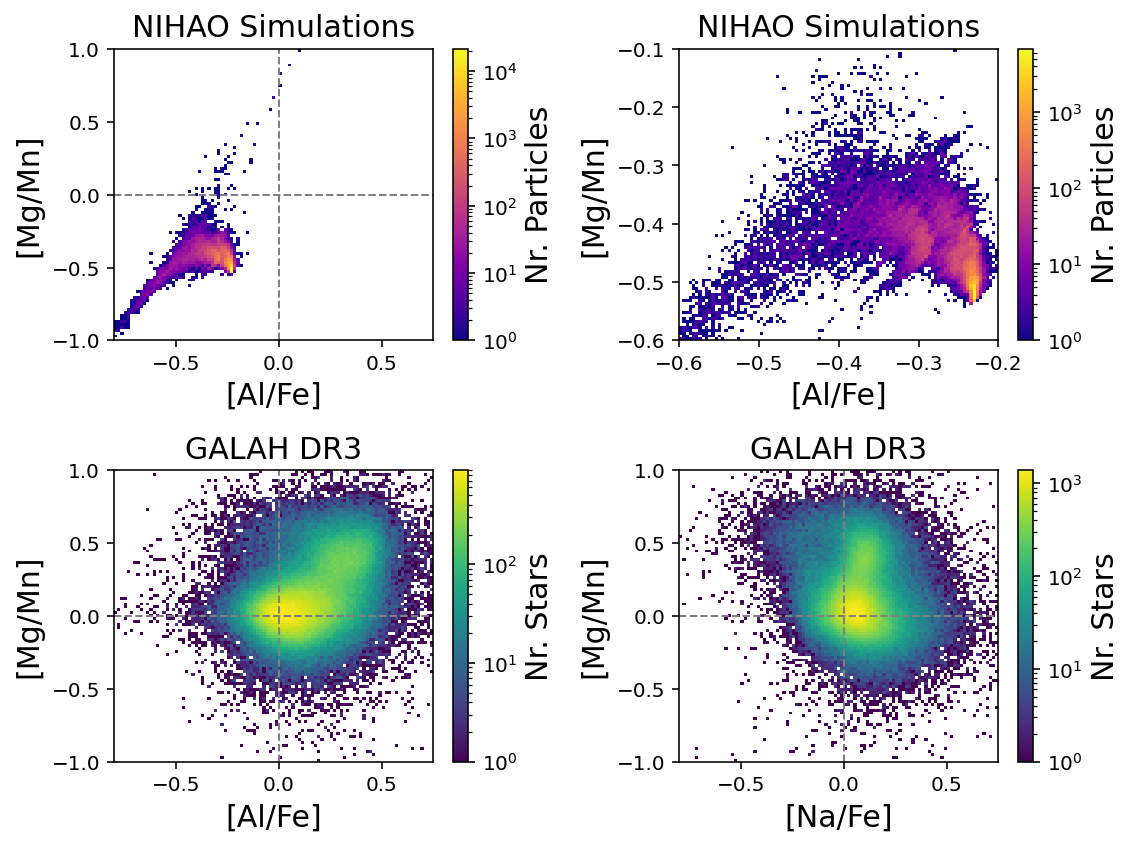

In [48]:
f, gs = plt.subplots(2,2,figsize=(8,6))#,sharex=True,sharey=True)

# Simulation: axes adjusted to show detail of plot
ax = gs[0,1]
p, x, y, s = ax.hist2d(
    sim['Al_H']-sim['Fe_H'],
    sim['Mg_H']-sim['Mn_H'],
    bins = (np.linspace(-0.6, -0.2, 100), np.linspace(-0.6, -0.1, 100)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr. Particles',fontsize=15)
ax.set_xlabel('[Al/Fe]',fontsize=15)
ax.set_ylabel('[Mg/Mn]',fontsize=15)
s.set_cmap('plasma')
ax.set_title('NIHAO Simulations',fontsize=15)
ax.axvline(0, color='grey',lw=1,ls='dashed')
ax.axhline(0, color = 'grey',lw=1,ls='dashed')

# Simulation: axes equal to observation plots for comparison
ax = gs[0,0]
p, x, y, s = ax.hist2d(
    sim['Al_H']-sim['Fe_H'],
    sim['Mg_H']-sim['Mn_H'],
    bins = (np.linspace(-0.8, 0.75, 100), np.linspace(-1., 1, 100)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr. Particles',fontsize=15)
ax.set_xlabel('[Al/Fe]',fontsize=15)
ax.set_ylabel('[Mg/Mn]',fontsize=15)
ax.set_title('NIHAO Simulations',fontsize=15)
s.set_cmap('plasma')
ax.axvline(0, color='grey',lw=1,ls='dashed')
ax.axhline(0, color = 'grey',lw=1,ls='dashed')

observation_quality_check_default = (
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg','Mn','Na']],axis=0)[0] # flags for all abundances measurements should be unflagged, here only Mg is tested
)

# Observation: against Al to compare to simulations
ax = gs[1,0]
p, x, y, s = ax.hist2d(
    obs['Al_fe'][observation_quality_check_default],
    obs['Mg_fe'][observation_quality_check_default]-obs['Mn_fe'][observation_quality_check_default],
    bins = (np.linspace(-0.8, 0.75, 100), np.linspace(-1., 1, 100)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s,  ax=ax)
c.set_label('Nr. Stars',fontsize=15)
ax.set_xlabel('[Al/Fe]',fontsize=15)
ax.set_ylabel('[Mg/Mn]',fontsize=15)
ax.set_title('GALAH DR3',fontsize=15)
ax.axvline(0, color='grey',lw=1,ls='dashed')
ax.axhline(0, color = 'grey',lw=1,ls='dashed')
s.set_cmap('viridis')

# Observation: against Na instead of Al, due to better observations 
ax = gs[1,1]
p, x, y, s = ax.hist2d(
    obs['Na_fe'][observation_quality_check_default],
    obs['Mg_fe'][observation_quality_check_default]-obs['Mn_fe'][observation_quality_check_default],
    bins = (np.linspace(-0.8, 0.75, 100), np.linspace(-1., 1, 100)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr. Stars',fontsize=15)
ax.set_xlabel('[Na/Fe]',fontsize=15)
ax.set_ylabel('[Mg/Mn]',fontsize=15)
ax.set_title('GALAH DR3',fontsize=15)
s.set_cmap('viridis')
ax.axvline(0, color='grey',lw=1,ls='dashed')
ax.axhline(0, color = 'grey',lw=1,ls='dashed')

observation_quality_check_default = (
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg','Mn','Al']],axis=0)[0] # flags for all abundances measurements should be unflagged, here only Mg is tested
)

plt.tight_layout()

plt.savefig('figures/mgmn_alfe.png', dpi=200,bbox_inches='tight')

# Part 4: Elemental abundance over time

Having determined that abundance planes were showing no scrutable or usable results in the simulations, we now consider age-abundance plots.

Caption:Simulation (top) vs observation (bottom) of [X/H] vs age. First plotting metallcity (X=Fe), and then barium (X=Ba). We see clear population streams in the simulated plots, but very little clear substructure in the observations.


/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


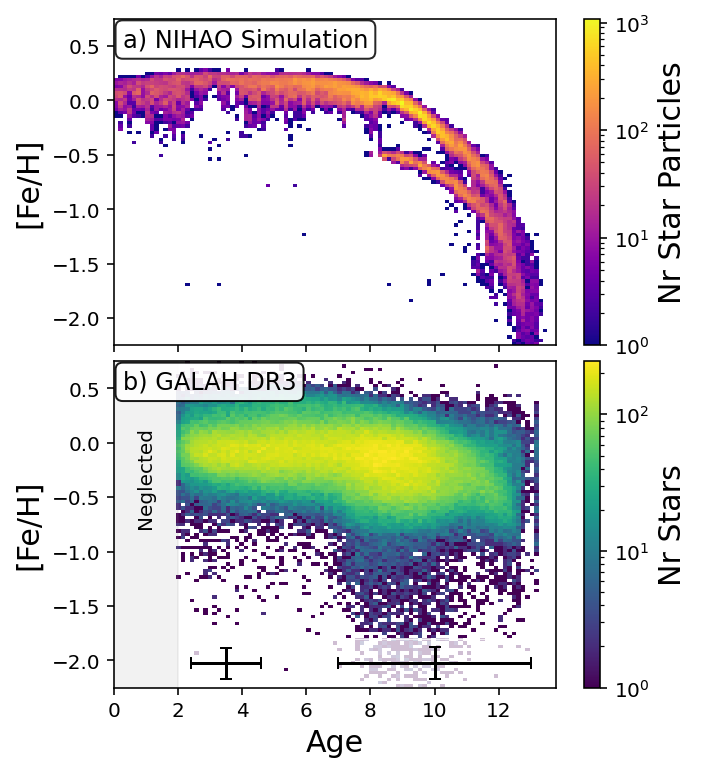

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


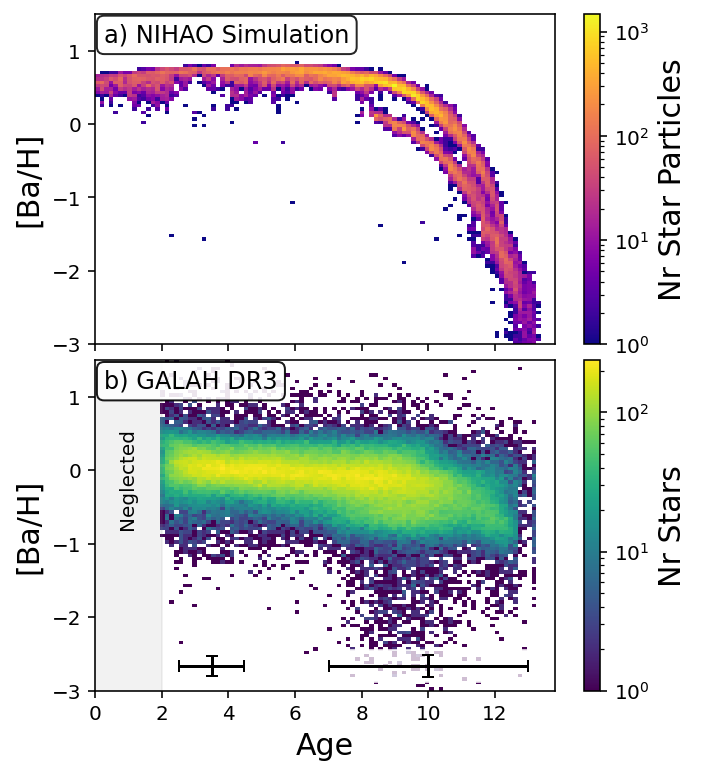

In [49]:
# First plotting metallicity [Fe/H] over age 
def plot_x_h_over_time(element = 'Fe'):
    
    f, gs = plt.subplots(2,1,figsize=(5,5.5),sharex=True,sharey=True)

    # Defining reasonable ranges over which we expect results 
    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Fe':
        y_bins = np.linspace(-2.25, 0.75, 100)
    else:
        y_bins = np.linspace(-3, 1.5, 100)

    # Simulation data 
    ax = gs[0]
    ax.text(0.02,0.915,'a) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        sim[element+'_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel('['+element+'/H]')
    plt.tight_layout()

    # Quality cut of GALAH data 
    if element == 'Fe':
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['e_fe_h'] < 0.1) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = obs['fe_h']
        e_ydata = obs['e_fe_h']
    else:
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['flag_'+element+'_fe'] == 0) & 
            (obs['e_'+element+'_fe'] < 0.1) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = obs[element+'_fe'] + obs['fe_h']
        e_ydata = obs['e_'+element+'_fe']
        
     
    # The exact same plot as above, but this time using the observational data instead of the simulations. Here we apply the quality cuts.
    ax = gs[1]
    ax.text(0.02,0.915,'b) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    error_position = [
        3.5,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    
    quality_cut2 = quality_cut & (obs['age_bstep'] <7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    
    #POLYGON EXPLANATION HERE!!!
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel('['+element+'/H]')
    plt.tight_layout(h_pad=0)
    plt.savefig('figures/'+element+'_H_time.png',dpi=200,bbox_inches='tight')

    plt.show()
    plt.close()
    
print('Caption:Simulation (top) vs observation (bottom) of [X/H] vs age. First plotting metallcity (X=Fe), and then barium (X=Ba). We see clear population streams in the simulated plots, but very little clear substructure in the observations.')

# Firstly plotting the planes defined above (that is, metallicity against age), and then all other elements- in this case Barium as an example.
plot_x_h_over_time()
plot_x_h_over_time(element='Ba')




## Ba/Fe over Age 

We now consider different variations of the age-abundance plot, in assessing which elemental combination produces the clearest results. Above, we plotted [X/H] over age, and now we test [X/Fe]. 

Caption:Simulation (top) vs observation (bottom) of [X/Fe] vs age. Showing Ba first, and then Al. Again, simulations show clearer substructure, though noticeable less than [X/H] plots above.


/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


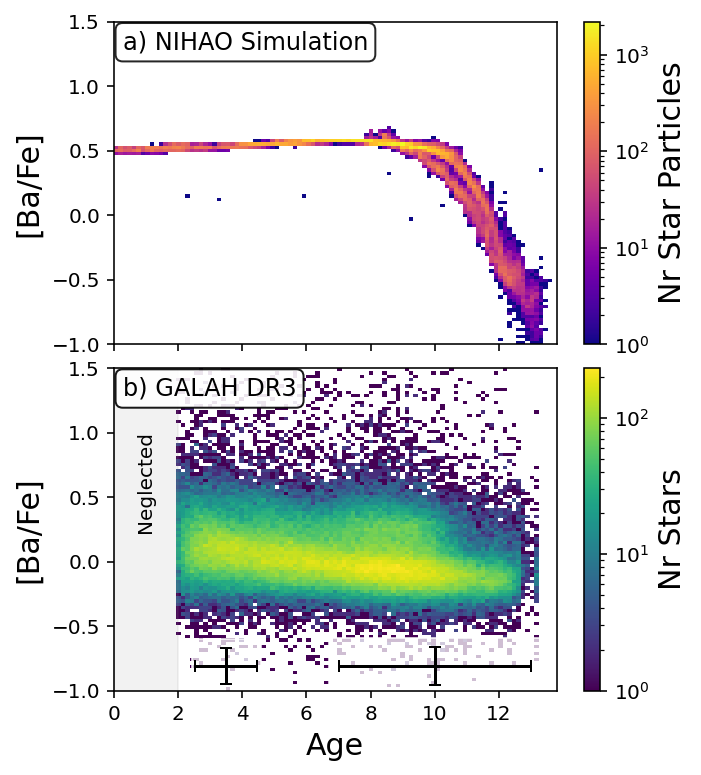

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


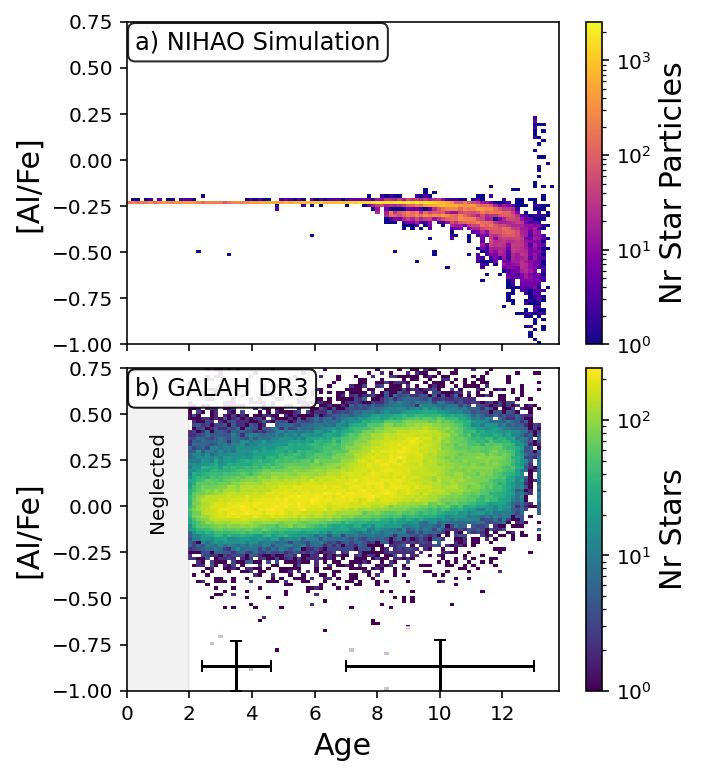

In [50]:
# Exact same process as above, except we now test each plot as a function of Fe, rather than H. 
def plot_x_fe_over_time(element = 'Fe'):
    
    f, gs = plt.subplots(2,1,figsize=(5,5.5),sharex=True,sharey=True)

    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Ba':
        y_bins = np.linspace(-1, 1.5, 100)
    elif element == 'Al':
        y_bins = np.linspace(-1, 0.75, 100)
    else:
        y_bins = np.linspace(-1, 1.5, 100)

    # Simulation data 
    ax = gs[0]
    ax.text(0.02,0.915,'a) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        sim[element+'_H']-sim['Fe_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel('['+element+'/Fe]')
    plt.tight_layout()

    # Quality cut of GALAH data 
    quality_cut = (
        (obs['flag_sp'] == 0) &
        (obs['flag_fe_h'] == 0) & 
        (obs['flag_'+element+'_fe'] == 0) & 
        (obs['e_'+element+'_fe'] < 0.1) & 
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
    )
    ydata = obs[element+'_fe']
    e_ydata = obs['e_'+element+'_fe']
        
    ax = gs[1]
    ax.text(0.02,0.915,'b) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    error_position = [
        3.5,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] <7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel('['+element+'/Fe]')
    plt.tight_layout(h_pad=0)

    plt.savefig('figures/'+element+'_Fe_time.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()
    
print('Caption:Simulation (top) vs observation (bottom) of [X/Fe] vs age. Showing Ba first, and then Al. Again, simulations show clearer substructure, though noticeable less than [X/H] plots above.')

plot_x_fe_over_time(element='Ba')
plot_x_fe_over_time(element='Al')

Caption:Simulation (top) vs observation (bottom) of [X/H] vs age. First plotting metallcity (X=Fe), and then barium (X=Ba). We see clear population streams in the simulated plots, but very little clear substructure in the observations.


/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


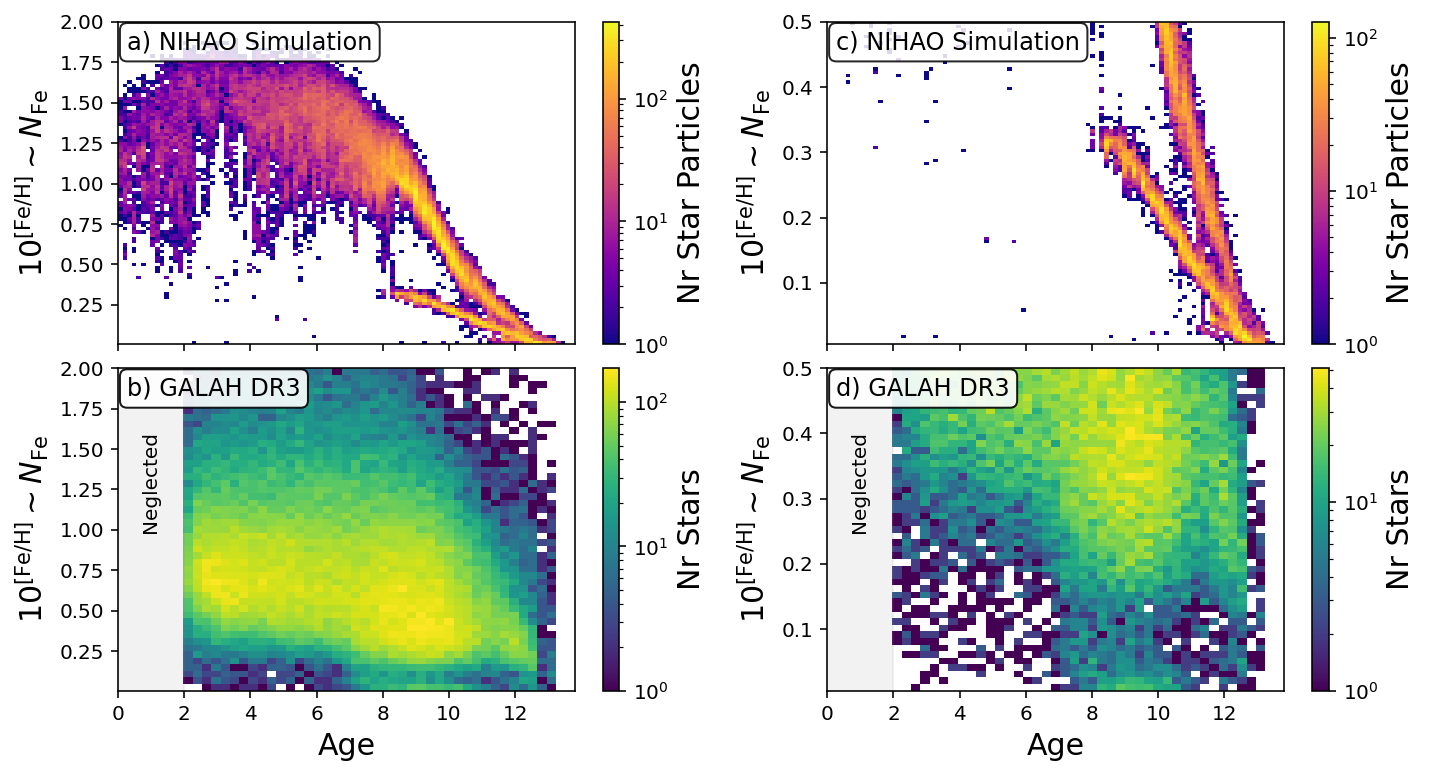

In [51]:
# First plotting metallicity [Fe/H] over age 
def plot_lin_x_h_over_time(element = 'Fe', ymax1 = 2, ymax2 = 0.5):
    
    f, gs = plt.subplots(2,2,figsize=(10,5.5),sharex=True)

    # Defining reasonable ranges over which we expect results 
    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Fe':
        y_bins = np.linspace(10**-2.25, ymax1, 100)

    # Simulation data 
    ax = gs[0,0]
    ax.text(0.02,0.915,'a) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        10**sim[element+'_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel(r'$10^\mathrm{['+element+'/H]} \sim N_\mathrm{Fe}$')
    plt.tight_layout()

    # Quality cut of GALAH data 
    if element == 'Fe':
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['e_fe_h'] < 0.1) & 
            (obs['snr_c2_iraf'] > 50) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = 10**obs['fe_h']
        e_ydata = 10**obs['e_fe_h']
     
    # The exact same plot as above, but this time using the observational data instead of the simulations. Here we apply the quality cuts.
    ax = gs[1,0]
    ax.text(0.02,0.915,'b) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (np.linspace(0, 13.8, 50),np.linspace(10**-2.25, ymax1, 50)),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel(r'$10^\mathrm{['+element+'/H]} \sim N_\mathrm{Fe}$')

    # Defining reasonable ranges over which we expect results 
    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Fe':
        y_bins = np.linspace(10**-2.25, ymax2, 100)

    # Simulation data 
    ax = gs[0,1]
    ax.text(0.02,0.915,'c) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        10**sim[element+'_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel(r'$10^\mathrm{['+element+'/H]} \sim N_\mathrm{Fe}$')
    plt.tight_layout()

    # Quality cut of GALAH data 
    if element == 'Fe':
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['e_fe_h'] < 0.1) & 
            (obs['snr_c2_iraf'] > 50) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = 10**obs['fe_h']
        e_ydata = 10**obs['e_fe_h']
     
    # The exact same plot as above, but this time using the observational data instead of the simulations. Here we apply the quality cuts.
    ax = gs[1,1]
    ax.text(0.02,0.915,'d) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (np.linspace(0, 13.8, 50),np.linspace(10**-2.25, ymax2, 50)),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel(r'$10^\mathrm{['+element+'/H]} \sim N_\mathrm{Fe}$')
    plt.tight_layout(h_pad=0)

    plt.show()
    return f
    
print('Caption:Simulation (top) vs observation (bottom) of [X/H] vs age. First plotting metallcity (X=Fe), and then barium (X=Ba). We see clear population streams in the simulated plots, but very little clear substructure in the observations.')

# Firstly plotting the planes defined above (that is, metallicity against age), and then all other elements- in this case Barium as an example.
f = plot_lin_x_h_over_time(ymax1=2,ymax2=0.5)
f.savefig('figures/Fe_H_lin_time.png',dpi=200,bbox_inches='tight');

In [52]:
# First plotting metallicity [Fe/H] over age 
def plot_lin_x_h_over_time(element = 'Fe', ymax = 2):
    
    f, gs = plt.subplots(2,1,figsize=(5,5.5),sharex=True,sharey=True)

    # Defining reasonable ranges over which we expect results 
    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Fe':
        y_bins = np.linspace(10**-2.25, 2, 100)

    # Simulation data 
    ax = gs[0]
    ax.text(0.02,0.915,'a) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        10**sim[element+'_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel('['+element+'/H]')
    plt.tight_layout()

    # Quality cut of GALAH data 
    if element == 'Fe':
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['e_fe_h'] < 0.1) & 
            (obs['snr_c2_iraf'] > 50) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = 10**obs['fe_h']
        e_ydata = 10**obs['e_fe_h']
     
    # The exact same plot as above, but this time using the observational data instead of the simulations. Here we apply the quality cuts.
    ax = gs[1]
    ax.text(0.02,0.915,'b) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (np.linspace(0, 13.8, 30),np.linspace(10**-2.25, 2, 30)),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
#     polygon = Polygon(
#         [
#             [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
#             [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
#             [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
#             [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
#         ], 
#         True,
#         fill=True,
#         color='w',
#         alpha=0.75
#     )
#     ax.add_patch(polygon)
    
#     ax.errorbar(
#         error_position[0],error_position[1],xerr=xerr,yerr=yerr,
#         capsize=3,color='k',ecolor='k',fillstyle='full'
#     )
    
#     error_position = [
#         3.5,
#         0.925*y_bins[0]+0.075*y_bins[-1],
#     ]
    
#     quality_cut2 = quality_cut & (obs['age_bstep'] <7)
#     xerr = np.median(obs['e_age_bstep'][quality_cut2])
#     yerr = 2*np.median(e_ydata[quality_cut2])
    
    
#     #POLYGON EXPLANATION HERE!!!
#     polygon = Polygon(
#         [
#             [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
#             [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
#             [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
#             [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
#         ], 
#         True,
#         fill=True,
#         color='w',
#         alpha=0.75
#     )
#     ax.add_patch(polygon)
    
#     ax.errorbar(
#         error_position[0],error_position[1],xerr=xerr,yerr=yerr,
#         capsize=3,color='k',ecolor='k',fillstyle='full'
#     )
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel(r'$10^\mathrm{['+element+'/H]}$')
    plt.tight_layout(h_pad=0)

    plt.show()
    plt.close()
    
print('Caption:Simulation (top) vs observation (bottom) of [X/H] vs age. First plotting metallcity (X=Fe), and then barium (X=Ba). We see clear population streams in the simulated plots, but very little clear substructure in the observations.')

# Firstly plotting the planes defined above (that is, metallicity against age), and then all other elements- in this case Barium as an example.
plot_lin_x_h_over_time(ybins = )

plt.savefig('figures/Fe_H_lin_time_zoom.png',dpi=200,bbox_inches='tight')


SyntaxError: invalid syntax (2128381720.py, line 125)

# Part 5: Data analysis: Separation significance and uncertainties 

## Table 1: Separation Significance for in-situ and accreted sequences

In [53]:
# These are 2 Gaussians combined into one equation. Defining the function...
def gauss2(x,a,x0,sigma,a1,x01,sigma1):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + a1*np.exp(-(x-x01)**2/(2*sigma1**2))

Caption: The bimodal histograms for each element. Shows the values we are working with - mean and std. dev.
0.13131313131313127 3007


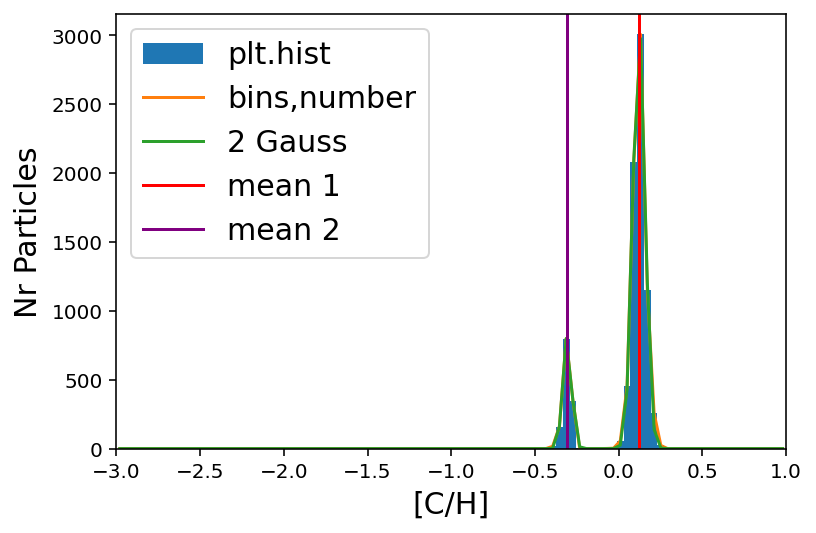

9.663465961560057 0.12226006747519645 0.03609984381012445 -0.3067295334244805 0.025836675739083527
0.13131313131313127 2963


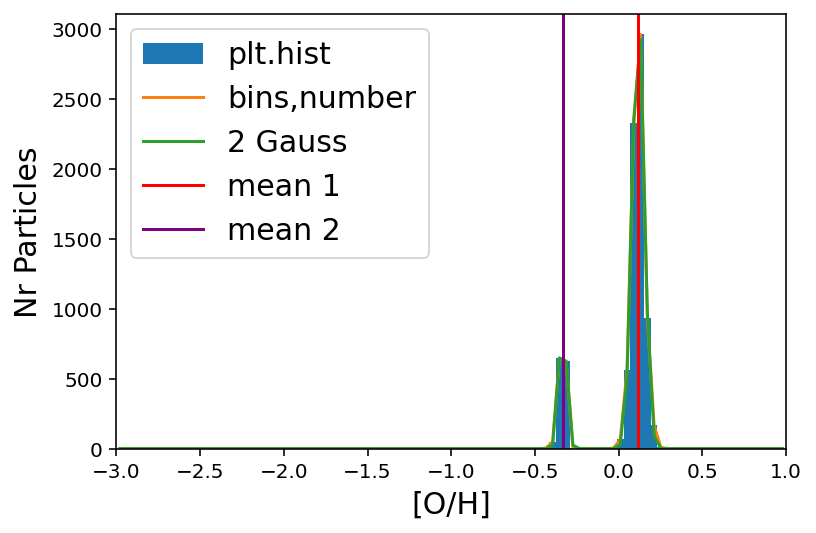

10.758823950924128 0.11772364797633895 0.03534215156636152 -0.3338432118150523 0.022639823499047133
-0.3131313131313129 2687


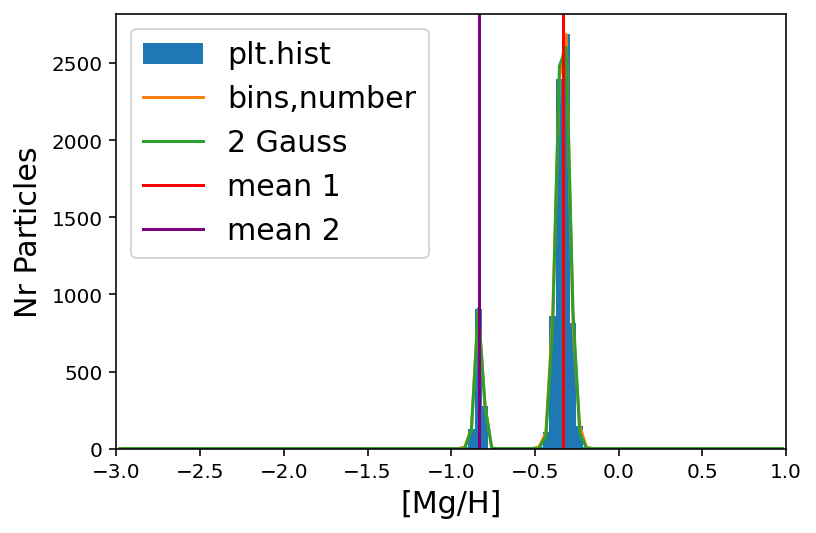

11.240667511326413 -0.33156504554743055 0.03837103116818422 -0.8334393144061409 0.022827951827691595
-0.2727272727272727 2672


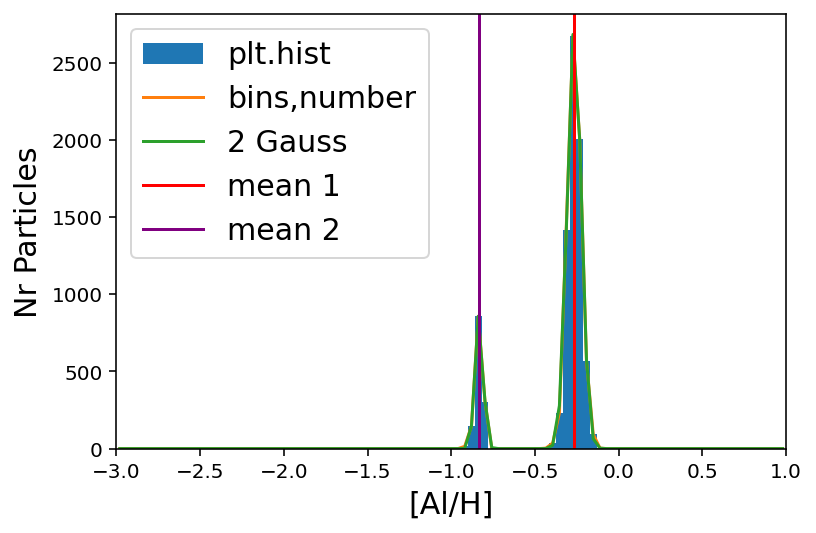

11.8471882394333 -0.2650257433622501 0.04142723202175514 -0.8331305357099587 0.02415050573885901
0.17171717171717193 2885


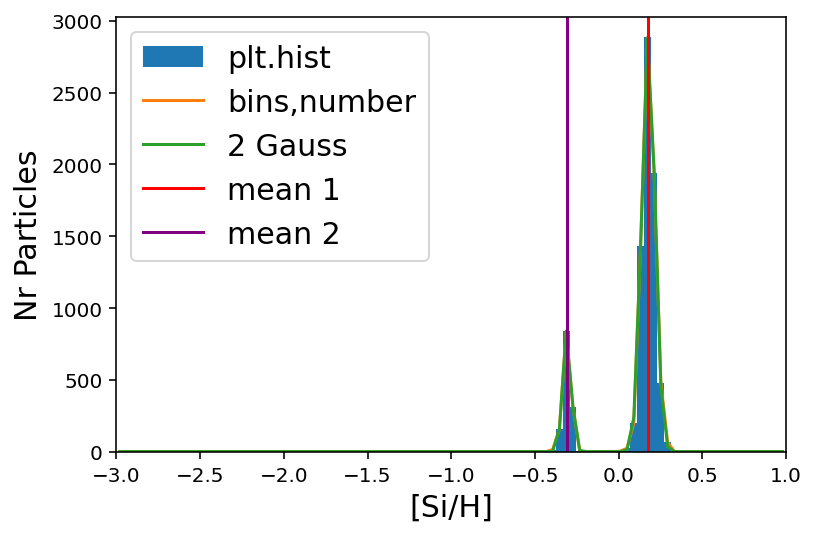

10.564510417100824 0.17767465988149223 0.03875647639671626 -0.3080027140067858 0.02472670495480551
-0.19191919191919182 2461


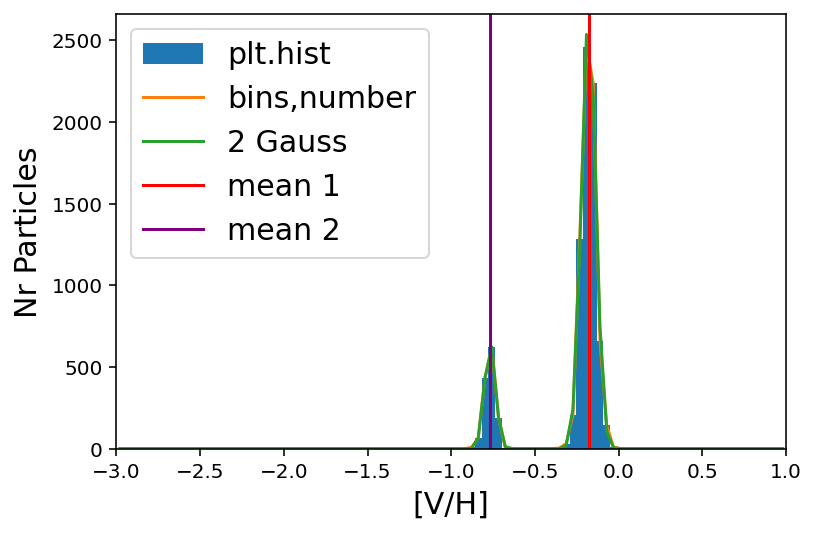

10.9877900334919 -0.17910480607154983 0.04268560564838136 -0.7684246689976701 0.0324738691134793
0.010101010101010166 2767


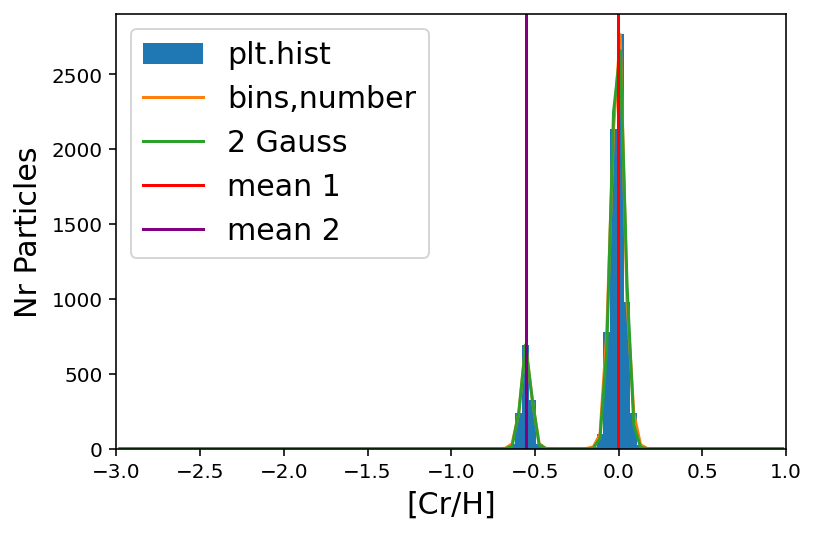

11.08321384713377 -0.003687069758885372 0.03928865319854386 -0.5523481940946372 0.03011689316091127
0.17171717171717193 2811


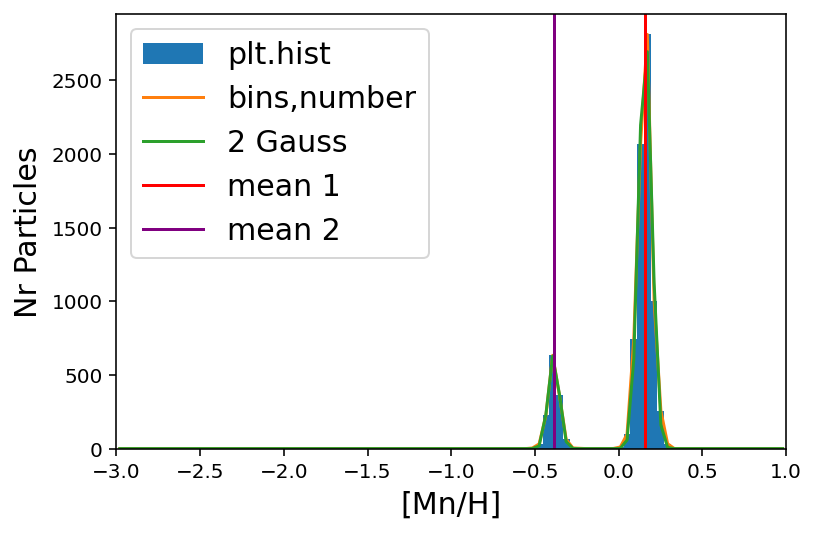

10.761383656079687 0.15918446419670798 0.03894317743386992 -0.3877923796142541 0.032663257636363116
-0.15151515151515116 2736


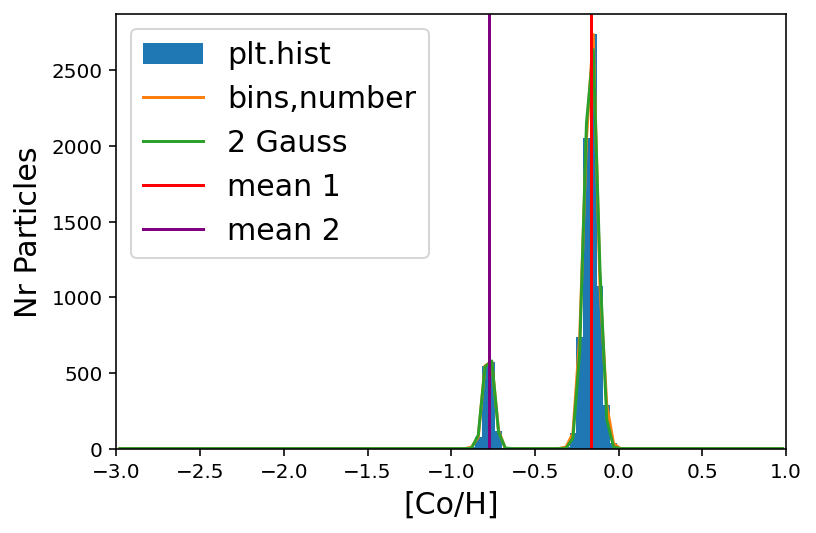

12.113665574465278 -0.16358704955676617 0.04023674392737749 -0.7762068910685606 0.03063649178833112
0.5353535353535357 2527


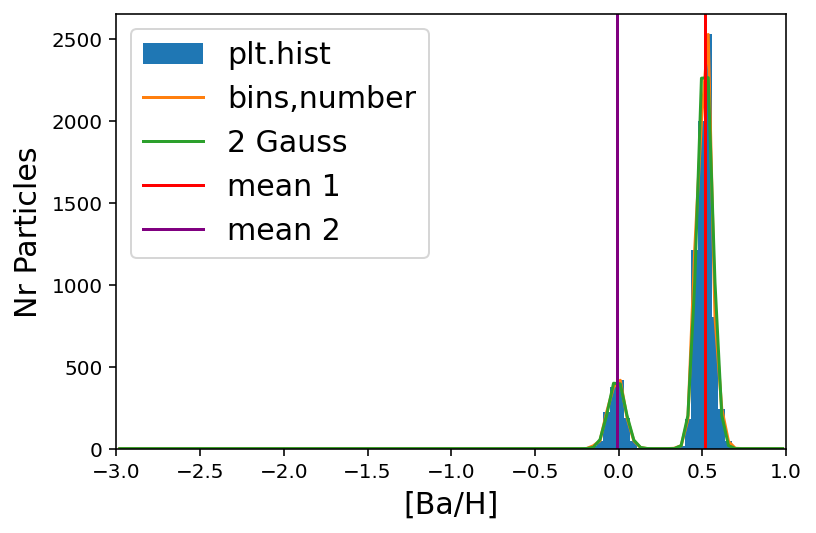

7.859044545755851 0.5152152759547446 0.045078526035583426 -0.010688694639571604 0.049455194491601746


In [54]:
# Defining the skeleton of the table 
table_text = [
    [r'\begin{table}'],
    [r'    \centering'],
    [r'    \caption{Separation significance for the simulated data between in-situ and accreted (accr.) sequences for abundances ratios [X/H] of ten elements X.}'],
    [r'    \begin{tabular}{cccccc}'],
    [r'    \hline'],
    [r'    Element & $\mu_\text{in-situ}$ & $\sigma_\text{in-situ}$ & $\mu_\text{accr.}$ & $\sigma_\text{accr.}$ & $r$\\'],
    [r'    \hline \hline']
]


# Boundaries for our calculations- between 4.5 and 5 Gyr, as plots above show this is where populations are clearest. 
def get_initial_mean_and_sigma(element, debug=True):
    age_limits = (sim['tform'] > 4.5) & (sim['tform'] < 5)
    data = sim[element+'_H'][age_limits]
    p = np.histogram(data,bins=np.linspace(-3,1,100))

    # Numbers and bin middle (from 101 bin beginnings/ends)
    number = p[0]
    bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

    peak_bin = bins[np.argmax(number)]
    peak_number = number[np.argmax(number)]
    print(peak_bin,peak_number)
    
    # This is simply "fitting" the 2 Gaussians we defined above to our data
    popt,pcov = curve_fit(
        gauss2,
        xdata = bins,
        ydata = number,
        p0=[peak_number,peak_bin,0.25,0.25*peak_number,peak_bin-0.5,0.1]
    )

    # The mean and std. dev of the two populations. 
    mean1 = popt[1]
    sigma1 = popt[2]
    mean2 = popt[4]
    sigma2 = popt[5]
    
    # Defining equation for separation significance
    r = abs(mean1 - mean2) / np.sqrt(sigma1**2 + sigma2**2) 
    
    if debug:
        plt.hist(
            data,bins=np.linspace(-3,1,100),
            label='plt.hist'
        )
        plt.plot(
            bins,
            number,
            label='bins,number'
        )
        
        plt.plot(
            bins,
            gauss2(bins,*popt),
            label='2 Gauss'
        )
        
        plt.xlim(-3,1)
        
        plt.axvline(mean1,c='r',label='mean 1')
        plt.axvline(mean2,c='purple',label='mean 2')
        plt.legend()
        
        plt.xlabel('['+element+'/H]')
        plt.ylabel('Nr Particles')
        
        plt.show()
        plt.close()

        print(r,mean1,sigma1,mean2,sigma2)

    
    return(r'    {['+element+'/H]}  & '+str(round(mean1,2))+' & '+str(round(sigma1, 2))+' & '+str(round(mean2, 2))+' & '+str(round(sigma2, 2))+' & '+str(round(r, 2))+r' \\')
print('Caption: The bimodal histograms for each element. Shows the values we are working with - mean and std. dev.')

# Creating a loop for the table to run through each element 
for element in ['C', 'O', 'Mg', 'Al', 'Si',  'V', 'Cr', 'Mn','Co', 'Ba']:
    table_text.append([get_initial_mean_and_sigma(element)])


# Tabulating information for direct comparison (Table 1 in associated paper)
table_text.append([r'    \hline'])
table_text.append([r'    \end{tabular}'])
table_text.append([r'    \label{tab:r_values_simulation}'])
table_text.append([r'\end{table}'])

np.savetxt('tables/separation_significance_two_sequences.tex',table_text,fmt='%s')



In [55]:

#     # Code that computes mu, sigma, r
#     p16, p50, p84 = np.percentile(sim[''+element+'_H'][low], q=[16,50,84])
#     mu_1 = p50
#     sigma_1 = (p84-p16)/2
    
#     p16, p50, p84 = np.percentile(sim[''+element+'_H'][high], q=[16,50,84])
#     mu_2 = p50
#     sigma_2 = (p84-p16)/2
    
#    r = abs(mu_1 - mu_2) / np.sqrt(sigma_1**2 + sigma_2**2) 

Caption: Plotting the allowed age uncertainty against the separation significance calculated above for each element. Shows two clear jumps where confidence increases significantly.


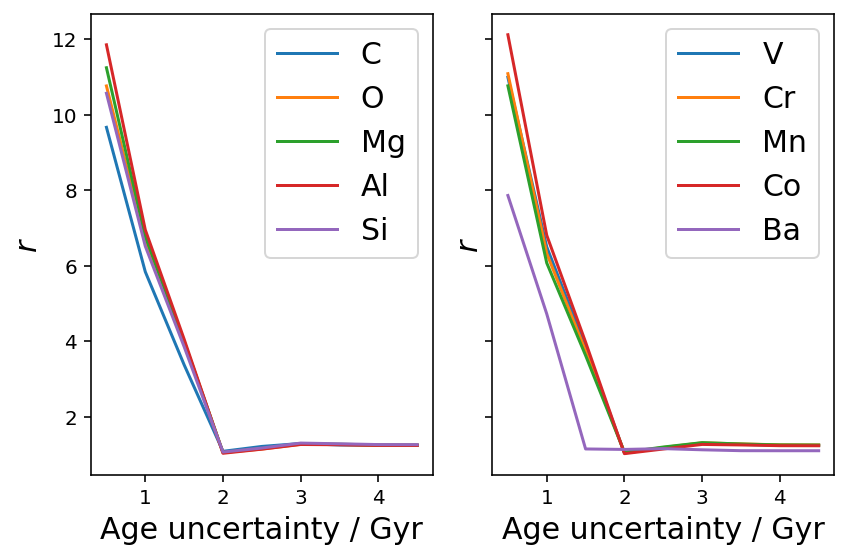

In [57]:
def get_initial_mean_and_sigma(element, age_limits = np.linspace(0.5,4.5,9), debug=True):

    sep_r_array = []
    
    for lower_age in age_limits:
        
        within_age_limits_array = (sim['tform'] > lower_age) & (sim['tform'] < 5)
        data = sim[element+'_H'][within_age_limits_array]

        if debug:
            
            plt.figure()
            
            plt.hist2d(
                sim['tform'],
                sim[element+'_H'],
                cmap='Greys',cmin=1,
                bins = (np.linspace(0,15,100),np.linspace(-2,1,100))
            )
            
            plt.hist2d(
                sim['tform'][within_age_limits_array],
                sim[element+'_H'][within_age_limits_array],
                cmap='Blues',cmin=1,
                bins = (np.linspace(0,15,100),np.linspace(-2,1,100))
            )            
            
            plt.show()
            plt.close()
        
        p = np.histogram(data,bins=np.linspace(-3,1,100))

        # Numbers and bin middle (from 101 bin beginnings/ends)
        number = p[0]
        bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

        peak_bin = bins[np.argmax(number)]
        peak_number = number[np.argmax(number)]

        # This is simply "fitting" the 2 Gaussians to our data
        popt,pcov = curve_fit(
            gauss2,
            xdata = bins,
            ydata = number,
            p0=[peak_number,peak_bin,0.25,0.5*peak_number,peak_bin-0.6,0.1]
        )

        # Again defining mean and std. dev for each population and eq for separation significance
        mean1 = popt[1]
        sigma1 = popt[2]
        mean2 = popt[4]
        sigma2 = popt[5]

        # Setting up plots to test code is working- shows selection of stars, and corresponding Gaussians
        if debug:
            plt.hist(
                data,bins=np.linspace(-3,1,100),
                label='plt.hist'
            )
            plt.plot(
                bins,
                number,
                label='bins,number'
            )

            plt.plot(
                bins,
                gauss2(bins,*popt),
                label='2 Gauss'
            )

            plt.xlim(-3,1)

            plt.axvline(mean1,c='r',label='mean 1')
            plt.axvline(mean2,c='purple',label='mean 2')
            plt.legend()

            plt.xlabel('['+element+'/H]')
            plt.ylabel('Nr Particles')

            plt.show()
            plt.close()

        r = abs(mean1 - mean2) / np.sqrt(sigma1**2 + sigma2**2)
        sep_r_array.append(r)
        
    return sep_r_array

age_limits = np.linspace(0.5,4.5,9)

sep_r_values = dict()

# Plotting the age uncertainty (within 4.5 and 5 Gyr) against separation significance, split onto two axes for clarity
f, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True)

for element in ['C', 'O', 'Mg', 'Al', 'Si']:

    sep_r_values[element] = get_initial_mean_and_sigma(element,age_limits,debug=False)

    ax1.plot(
        5 - age_limits,
        sep_r_values[element],
        label=element
    )
ax1.legend()

for element in ['V', 'Cr', 'Mn','Co', 'Ba']:
    sep_r_values[element] = get_initial_mean_and_sigma(element,age_limits,debug=False)

    ax2.plot(
        5 - age_limits,
        sep_r_values[element],
        label=element
    )
ax2.legend()

ax1.set_xlabel('Age uncertainty / Gyr')
ax2.set_xlabel('Age uncertainty / Gyr')
ax1.set_ylabel('$r$')
ax2.set_ylabel('$r$')
plt.tight_layout()

print('Caption: Plotting the allowed age uncertainty against the separation significance calculated above for each element. Shows two clear jumps where confidence increases significantly.')

plt.savefig('figures/Age_vs_r.png')

# Table 2
## Measurement uncertainties required for significance

In [58]:
# First, defining the function that will calculate the mean and sigma values for each Gaussian 

def get_initial_mean_and_sigma(element, debug=False):
    age_limits = (sim['tform'] > 4) & (sim['tform'] < 5)
    data = sim[element+'_H'][age_limits]
    p = np.histogram(data,bins=100)

    # Numbers and bin middle (from 101 bin beginnings/ends)
    number = p[0]
    bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

    peak_bin = bins[np.argmax(number)]
    peak_number = number[np.argmax(number)]

    # This is simply "fitting" the 2 Gaussians to our data
    popt,pcov = curve_fit(
        gauss2,
        xdata = bins,
        ydata = number,
        p0=[peak_number,peak_bin,0.25,0.5*peak_number,peak_bin-0.7,0.1]
    )

    mean1 = popt[1]
    sigma1 = popt[2]
    mean2 = popt[4]
    sigma2 = popt[5]

    if debug:
        plt.hist(
            data,bins=np.linspace(-3,1,100),
            label='plt.hist'
        )
        plt.plot(
            bins,
            number,
            label='bins,number'
        )

        plt.plot(
            bins,
            gauss2(bins,*popt),
            label='2 Gauss'
        )

        plt.xlim(-3,1)

        plt.axvline(mean1,c='r',label='mean 1')
        plt.axvline(mean2,c='purple',label='mean 2')
        plt.legend()

        plt.xlabel('['+element+'/H]')
        plt.ylabel('Nr Particles')

        plt.show()
        plt.close()
    

    
    # Obtaining the mean error of the measurements taken by GALAH 
    mean_error = np.mean((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])])

    # Calculating what percentage of the stars observed had measurements available for each element 
    number_observations= (len((obs['e_'+element+'_fe'])))
    non_zero_number = (len((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])]))
    fraction_available = non_zero_number/number_observations
    percent_available = fraction_available*100

    return(mean1, sigma1, mean2, sigma2, mean_error)
#     # Defining the columns of Table 2, found in the paper
#     return(mean1, sigma1, mean2, sigma2, mean_error)

 


Caption: Plotting noise in the observation measurements against the separation significance for each element. Horizontal dashed lines show where the confidence intervals of 68% (at r=1) and 95% (r=2) lie. We see there is little distinction between the elements.


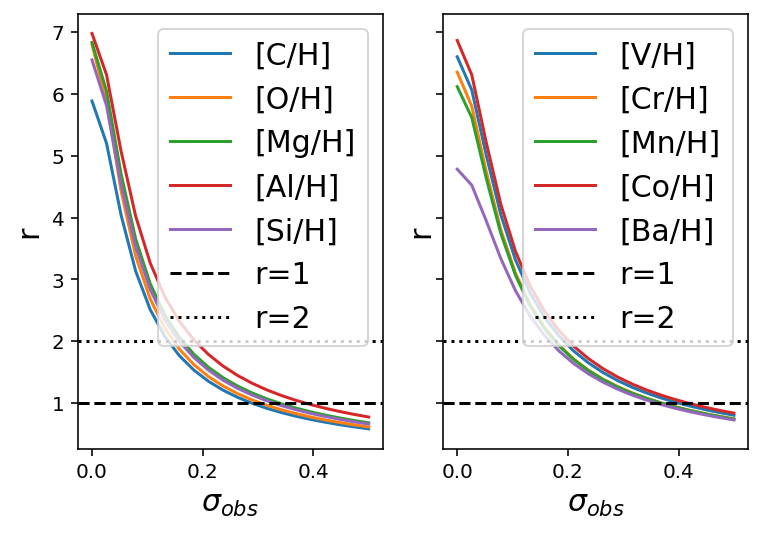

In [59]:
f, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True)

for element in ['C', 'O', 'Mg', 'Al', 'Si']:
    
    peaks = get_initial_mean_and_sigma(element)
    
    sigma_obs = np.linspace(0,0.5,20)
    sigma_1obs = np.sqrt(peaks[1]**2 + sigma_obs**2)
    sigma_2obs = np.sqrt(peaks[3]**2 + sigma_obs**2)
    r_obs = abs(peaks[0] - peaks[2]) / np.sqrt(sigma_1obs**2 + sigma_2obs**2) 
    r_sim = abs(peaks[0] - peaks[2]) / np.sqrt(peaks[1]**2 + peaks[3]**2) 

    # Interpolate and find sigma_obs values that match r=1, 2
    r_1_68 = sigma_obs[np.argmin(np.abs(r_obs - 1))]
    r_1_95 = sigma_obs[np.argmin(np.abs(r_obs - 2))]

    ax1.plot(
        sigma_obs,
        r_obs,
        label='['+element+'/H]'
    )
ax1.set_xlabel('$\sigma_{obs}$')
ax1.set_ylabel('r')
ax1.axhline(1,c='k',ls='dashed',label='r=1')
ax1.axhline(2, c='k',ls='dotted',label='r=2')
ax1.legend()

for element in ['V', 'Cr', 'Mn','Co', 'Ba']:
    
    peaks = get_initial_mean_and_sigma(element)
    
    #sep_r_values[element] = get_initial_mean_and_sigma(element,age_limits,debug=False)
    sigma_obs = np.linspace(0,0.5,20)
    sigma_1obs = np.sqrt(peaks[1]**2 + sigma_obs**2)
    sigma_2obs = np.sqrt(peaks[3]**2 + sigma_obs**2)
    r_obs = abs(peaks[0] - peaks[2]) / np.sqrt(sigma_1obs**2 + sigma_2obs**2) 
    r_sim = abs(peaks[0] - peaks[2]) / np.sqrt(peaks[1]**2 + peaks[3]**2) 

    # Interpolate and find sigma_obs values that match r=1, 2
    r_1_68 = sigma_obs[np.argmin(np.abs(r_obs - 1))]
    r_1_95 = sigma_obs[np.argmin(np.abs(r_obs - 2))]

    ax2.plot(
        sigma_obs,
        r_obs,
        label='['+element+'/H]'
    )
ax2.set_xlabel('$\sigma_{obs}$')
ax2.set_ylabel('r')
ax2.axhline(1,c='k',ls='dashed',label='r=1')
ax2.axhline(2, c='k',ls='dotted',label='r=2')
ax2.legend()


print('Caption: Plotting noise in the observation measurements against the separation significance for each element. Horizontal dashed lines show where the confidence intervals of 68% (at r=1) and 95% (r=2) lie. We see there is little distinction between the elements.')

plt.savefig('figures/element_vs_separation_significance.pdf',dpi=200,bbox_inches='tight')

#np.savefig('figures/sigma_obs_vs_r.tex',table_text_2,fmt='%s')

In [60]:
# Outlining the skeleton of Table 2 
table_text_2 = [
    [r'\begin{table}'],
    [r'    \centering'],
    [r'    \caption{Observational uncertainties for each element that allow to separate the in-situ and accreted sequences at $8-9\,\mathrm{Gyr}$ with 95\% ($r>2$) and 68\% ($r>1$) certainty. The last rows report the percentage of measurements and their the median uncertainties for the element reported by GALAH DR3 (as indicators of how often and how well the element can be measured.}'],
    [r'    \begin{tabular}{ccccc}'],
    [r'    \hline'],
    [r'    Element & $\sigma_\text{obs}$ 95\% & $\sigma_\text{obs}$ 68\% & Det. Rate & $\sigma_\text{GALAH}$ \\'],
    [r'    \hline \hline']
]


# Using similar logic as above to determine the means and std. devs of the two Gaussians 
def get_initial_mean_and_sigma(element, debug=False):
    age_limits = (sim['tform'] > 4) & (sim['tform'] < 5)
    data = sim[element+'_H'][age_limits]
    p = np.histogram(data,bins=100)

    # Numbers and bin middle (from 101 bin beginnings/ends)
    number = p[0]
    bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

    peak_bin = bins[np.argmax(number)]
    peak_number = number[np.argmax(number)]

    # This is simply "fitting" the 2 Gaussians to our data
    popt,pcov = curve_fit(
        gauss2,
        xdata = bins,
        ydata = number,
        p0=[peak_number,peak_bin,0.25,0.5*peak_number,peak_bin-0.7,0.1]
    )

    mean1 = popt[1]
    sigma1 = popt[2]
    mean2 = popt[4]
    sigma2 = popt[5]

    if debug:
        plt.hist(
            data,bins=np.linspace(-3,1,100),
            label='plt.hist'
        )
        plt.plot(
            bins,
            number,
            label='bins,number'
        )

        plt.plot(
            bins,
            gauss2(bins,*popt),
            label='2 Gauss'
        )

        plt.xlim(-3,1)

        plt.axvline(mean1,c='r',label='mean 1')
        plt.axvline(mean2,c='purple',label='mean 2')
        plt.legend()

        plt.xlabel('['+element+'/H]')
        plt.ylabel('Nr Particles')

        plt.show()
        plt.close()
    
    # Defining the values for measurement noise in the observation data 
    sigma_obs = np.linspace(0,0.5,20)
    sigma_1obs = np.sqrt(sigma1**2 + sigma_obs**2)
    sigma_2obs = np.sqrt(sigma2**2 + sigma_obs**2)
    r_obs = abs(mean1 - mean2) / np.sqrt(sigma_1obs**2 + sigma_2obs**2) 
    r_sim = abs(mean1 - mean2) / np.sqrt(sigma1**2 + sigma2**2) 
    
    
    # Interpolate and find sigma_obs values that match r=1, 2
    r_1_68 = sigma_obs[np.argmin(np.abs(r_obs - 1))]
    r_1_95 = sigma_obs[np.argmin(np.abs(r_obs - 2))]

    
    # Obtaining the mean error of the measurements taken by GALAH 
    mean_error = np.mean((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])])

    # Calculating what percentage of the stars observed had measurements available for each element 
    number_observations= (len((obs['e_'+element+'_fe'])))
    non_zero_number = (len((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])]))
    fraction_available = non_zero_number/number_observations
    percent_available = fraction_available*100
        
    # Defining the columns of Table 2
    return(r'    {['+element+'/H]}  & '+str(round(r_1_95,3))+' & '+str(round(r_1_68, 3))+' & '+str(round(percent_available, 2))+' & '+str(round(mean_error, 3))+r' \\')

# Looping through each element to generate corresponding values for the table 
for element in ['C', 'O', 'Mg', 'Al', 'Si',  'V', 'Cr', 'Mn','Co', 'Ba']:
    table_text_2.append([get_initial_mean_and_sigma(element,debug=False)])

table_text_2.append([r'    \hline'])
table_text_2.append([r'    \end{tabular}'])
table_text_2.append([r'    \label{tab:r_values_simulation}'])
table_text_2.append([r'\end{table}'])

np.savetxt('tables/table_2_test.tex',table_text_2,fmt='%s')

# The potential of Ages: Cleaning chemical selections

It has been shown that ages are extremely helpful in the stellar disk, to separate (typically young) low- from (typically old) high-alpha disk stars (Buder et al. 2019). Both when chemically separating the two disk populations (Buder et al. 2019) as well as accreted stars from in-situ (Buder et al. 2022), significant contamination or overlaps were discovered.

Here, we are now testing the potential of ages as another conserved stellar property to clean the contamination of chemical selections.

We start by selecting accreted stars chemically in the [Na/Fe] vs. [Mg/Fe] plane as done by Buder et al. (2022).

In [61]:
# for index, nafe_upper_limit in enumerate([0.2,0.1,0.0,-0.1]):
#     if index != 1:
# #         print(index, nafe_upper_lmit)

Caption: The first plot shows an abundance-abundance plane, with a selection of accreted stars, seperate to the majority in-situ population. The different colours show an increasingly large selection of these stars, which entails increasingly large overlap between populations. This is demonstrated by the proceeding plots, which show less and less clarity between populations.


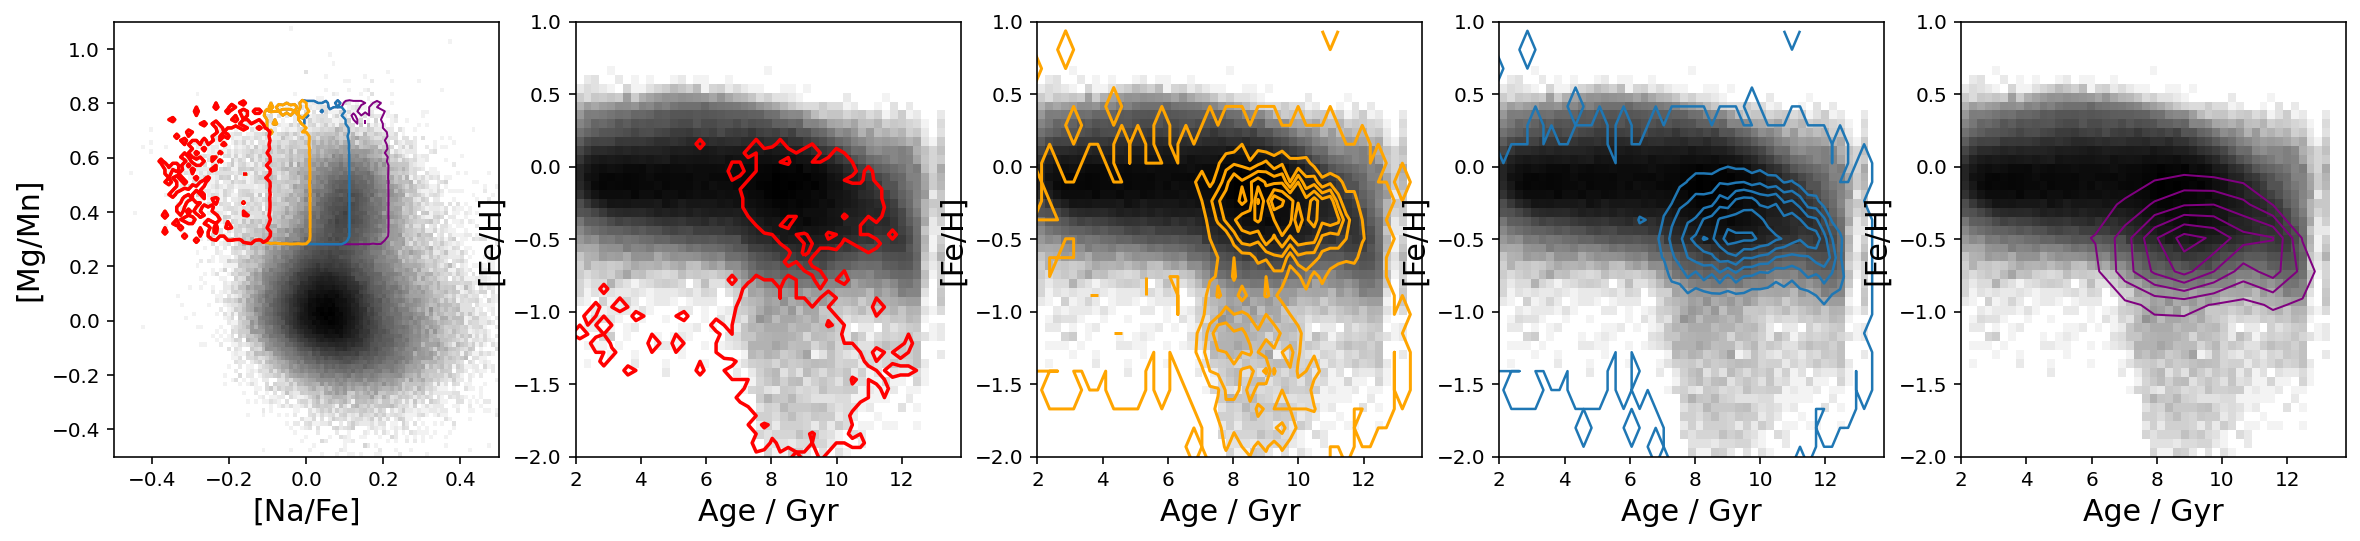

In [62]:
# Defining a function that will be used to plot the idea behind using ages to clean chemical selections
def plot_nafe_selections():
    
    # Outlining quality cuts for GALAH data 
    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )

    f, gs = plt.subplots(1,5,figsize=(20,4))

    # Defining the upper boundaries for the four different selections (in order of colour)

    colors = ['purple','C0','orange','red']
    for index, nafe_upper_limit in enumerate([0.2,0.1,0.0,-0.1]):


        selection_na_fe = [-0.4,nafe_upper_limit]
        selection_mg_mn = [0.3,0.8]

        selection_accreted = (
            observation_quality_check & 
            (obs['Na_fe'] > selection_na_fe[0]) & 
            (obs['Na_fe'] < selection_na_fe[1]) &
            (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
            (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) 
        )

        # Plotting abundance-abundance plane
        ax = gs[0]

        if index == 0:
            ax.set_xlabel('[Na/Fe]')
            ax.set_ylabel('[Mg/Mn]')

            # Plotting the base of stars observed by [Na/Fe] v [Mg/Mn]
            p = ax.hist2d(
                obs['Na_fe'][observation_quality_check],
                obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
                bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
                cmin = 1, cmap='Greys',
                norm = LogNorm()
            )

        h = np.histogram2d(
            obs['Na_fe'][selection_accreted], 
            obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
            bins=(np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.0,100)))

        # Adding the selections (in different colours) on top of the base stars 
        ax.contour(
            h[0].T,
            extent=[h[1][0],h[1][-1],h[2][0],h[2][-1]],
            levels=[1,],
            colors=colors[index],
            linewidths=[1+0.25*index,]
        )

        # Starting by indexing the first selection in the upper limit of uncertainty (index ==3) 

        ax = gs[1]

        if index == 3:
            ax.set_xlabel('Age / Gyr')
            ax.set_ylabel('[Fe/H]')

            p, x, y, s = ax.hist2d(
                obs['age_bstep'][observation_quality_check],
                obs['fe_h'][observation_quality_check],
                bins = (np.linspace(2,13.8,50), np.linspace(-2,1,50)),
                cmin = 1,cmap='Greys',
                norm = LogNorm()
            );

            h = np.histogram2d(
                obs['age_bstep'][selection_accreted], 
                obs['fe_h'][selection_accreted],
                bins=(np.linspace(2,13.8,50), np.linspace(-2,1,50))
            )

            ax.contour(
                h[0].T,
                extent=[h[1][0]+0.5*(h[1][0]-h[1][1]),h[1][-1]+0.5*(h[1][0]-h[1][1]),h[2][0]+0.5*(h[2][0]-h[2][1]),h[2][-1]+0.5*(h[2][0]-h[2][1])],
                levels=[1,],
                colors=colors[index],
                linewidths = [1+0.25*index,]
            )
        
        ax = gs[2]

        if index == 2:
            ax.set_xlabel('Age / Gyr')
            ax.set_ylabel('[Fe/H]')

            p, x, y, s = ax.hist2d(
                obs['age_bstep'][observation_quality_check],
                obs['fe_h'][observation_quality_check],
                bins = (np.linspace(2,13.8,50), np.linspace(-2,1,50)),
                cmin = 1,cmap='Greys',
                norm = LogNorm()
            );

            h = np.histogram2d(
                obs['age_bstep'][selection_accreted], 
                obs['fe_h'][selection_accreted],
                bins=(np.linspace(2,13.8,50), np.linspace(-2,1,25))
            )

            ax.contour(
                h[0].T,
                extent=[h[1][0]+0.5*(h[1][0]-h[1][1]),h[1][-1]+0.5*(h[1][0]-h[1][1]),h[2][0]+0.5*(h[2][0]-h[2][1]),h[2][-1]+0.5*(h[2][0]-h[2][1])],
#                levels=[1,],
                colors=colors[index],
                linewidths = [1+0.25*index,]
            )
        
        ax = gs[3]

        if index == 1:
            ax.set_xlabel('Age / Gyr')
            ax.set_ylabel('[Fe/H]')

            p, x, y, s = ax.hist2d(
                obs['age_bstep'][observation_quality_check],
                obs['fe_h'][observation_quality_check],
                bins = (np.linspace(2,13.8,50), np.linspace(-2,1,50)),
                cmin = 1,cmap='Greys',
                norm = LogNorm()
            );

            h = np.histogram2d(
                obs['age_bstep'][selection_accreted], 
                obs['fe_h'][selection_accreted],
                bins=(np.linspace(2,13.8,50), np.linspace(-2,1,25))
            )

            ax.contour(
                h[0].T,
                extent=[h[1][0]+0.5*(h[1][0]-h[1][1]),h[1][-1]+0.5*(h[1][0]-h[1][1]),h[2][0]+0.5*(h[2][0]-h[2][1]),h[2][-1]+0.5*(h[2][0]-h[2][1])],
#                levels=[1,],
                colors=colors[index],
                linewidths = [1+0.25*index,]
            )

        ax = gs[4]

        if index == 0:
            ax.set_xlabel('Age / Gyr')
            ax.set_ylabel('[Fe/H]')

            p, x, y, s = ax.hist2d(
                obs['age_bstep'][observation_quality_check],
                obs['fe_h'][observation_quality_check],
                bins = (np.linspace(2,13.8,50), np.linspace(-2,1,50)),
                cmin = 1,cmap='Greys',
                norm = LogNorm()
            );

            h = np.histogram2d(
                obs['age_bstep'][selection_accreted], 
                obs['fe_h'][selection_accreted],
                bins=(np.linspace(2,13.8,15), np.linspace(-2,1,15))
            )

            hp5 = np.percentile(h[0],q=[50])
            h[0][h[0]<int(hp5)] = np.NaN
            
            ax.contour(
                h[0].T,
                extent=[h[1][0]+0.5*(h[1][0]-h[1][1]),h[1][-1]+0.5*(h[1][0]-h[1][1]),h[2][0]+0.5*(h[2][0]-h[2][1]),h[2][-1]+0.5*(h[2][0]-h[2][1])],
                #levels=[0.9999,],
                colors=colors[index],
                linewidths = [1+0.25*index,]
            )


print('Caption: The first plot shows an abundance-abundance plane, with a selection of accreted stars, seperate to the majority in-situ population. The different colours show an increasingly large selection of these stars, which entails increasingly large overlap between populations. This is demonstrated by the proceeding plots, which show less and less clarity between populations.')
plot_nafe_selections()


# Part 5: Discussion 
Here, we plot a grid-like comparison of the three different stellar sequences identified in the simulated age-abundance plot, and compare their chemical and kinematic features. 

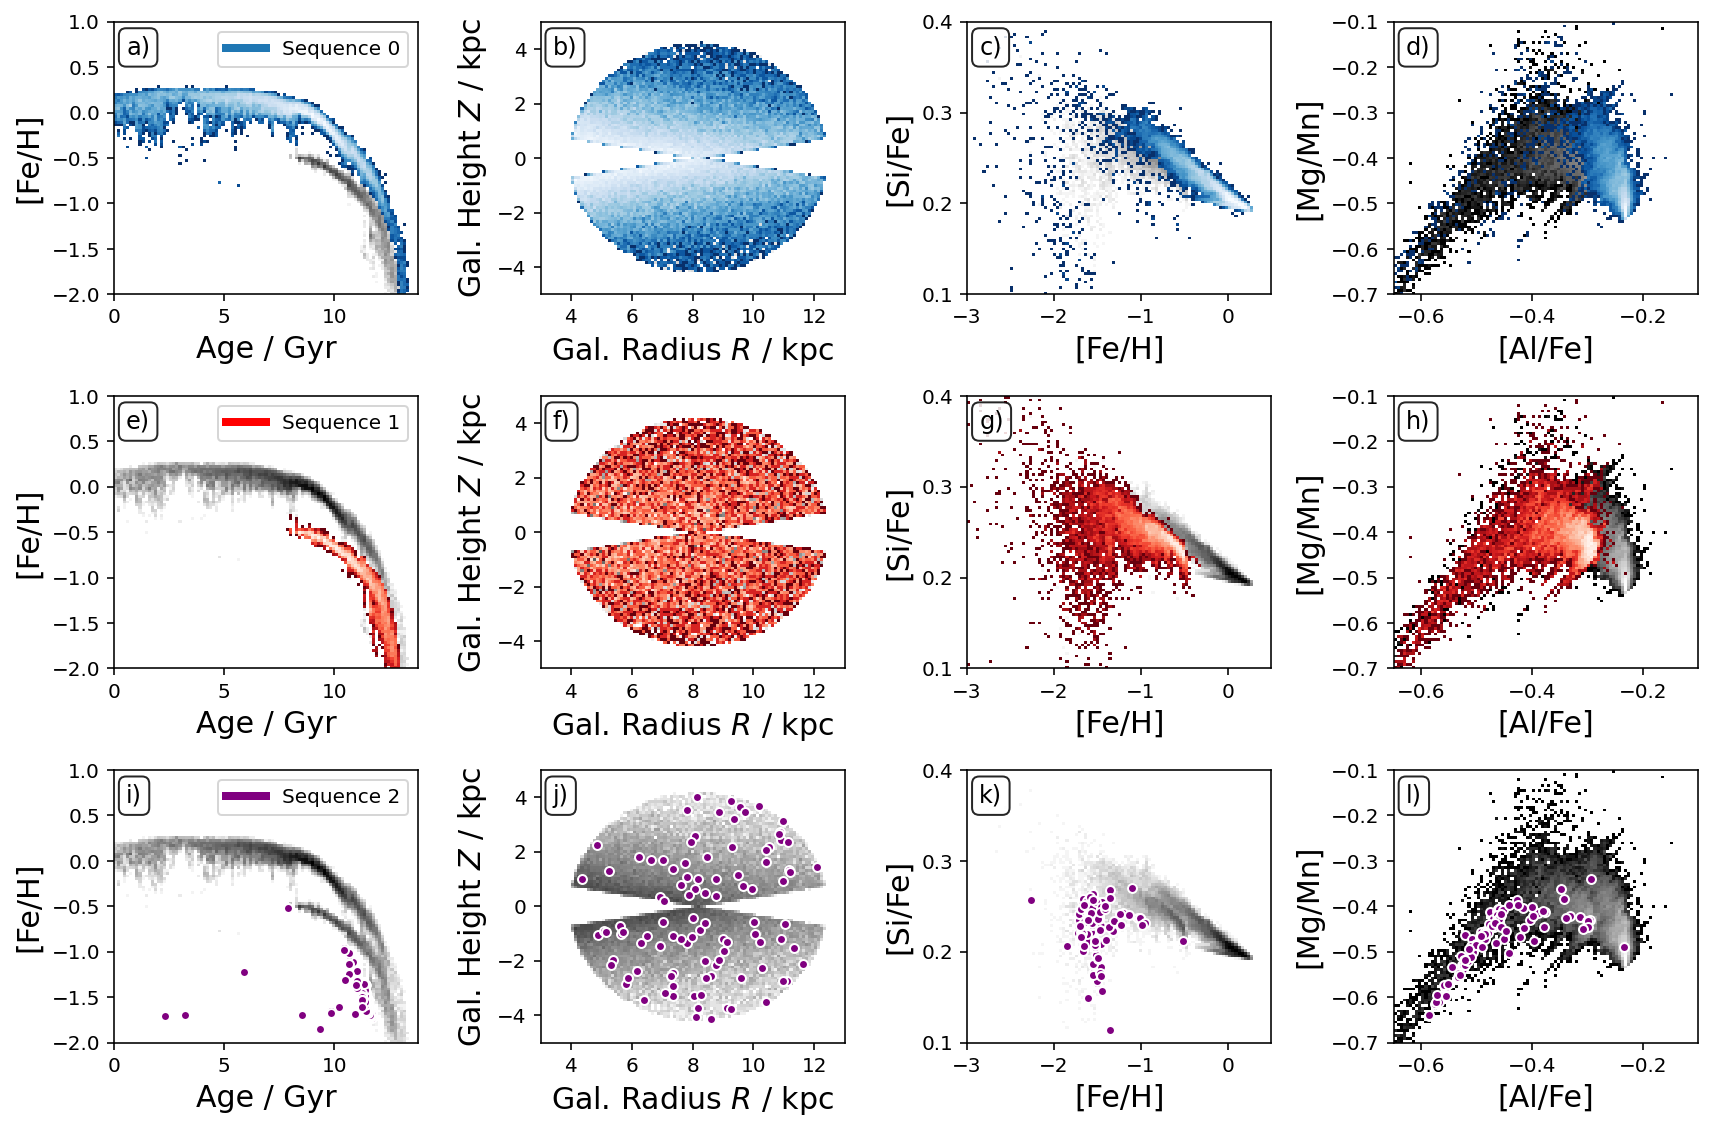

In [85]:
def plot_Alfe_mgmn_dissection_sim(save=False):

    f, gs = plt.subplots(3,4,figsize=(12,8))

    # Selecting the stars that are members of the topmost population of the simulated plot (BLUE)
    selection_sequence1 = (
        (sim['Fe_H'] > -0.2) |
        ((sim['Fe_H'] > -1.) & (13.80-sim['tform'] < 7)) |
        (10**(sim['Fe_H']+0.2) > 1.9 - 0.15*(13.40-sim['tform']))
    )
    
    # The middle stream - most likely accreted (RED)
    selection_sequence2 = (
        ~ selection_sequence1 &
        (sim['tform'] > 0.5) & 
        (sim['tform'] < 6) &
        (10**(sim['Fe_H']+0.3) > 1.8 - 0.15*(13.80-sim['tform']))
    )
    
    # The bottom, small stream (PURPLE)
    selection_sequence3 = (
        (~selection_sequence1) &
        (~selection_sequence2)
    )
    
    colors = ['C0','r','purple']
    cmaps = ['Blues','Reds','Purples']
    
    for index, selection in enumerate([selection_sequence1,selection_sequence2,selection_sequence3]):

        
        
        # Age-Metallicity-Relation

        x_bins = np.linspace(0,13.8,100)
        y_bins = np.linspace(-2,1,100)

        panels = ['a)','e)','i)']
        
        ax = gs[index,0]
        ax.set_xlabel('Age / Gyr')
        ax.set_ylabel('[Fe/H]')
        ax.text(0.04,0.95,panels[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

        p, x, y, s = ax.hist2d(
            # Ensuring plots are over age, and consistent with b_age_step
            13.8 - sim['tform'],
            sim['Fe_H'],
            bins = (x_bins, y_bins),
            cmin = 1,cmap='Greys',
            norm = LogNorm()
        );
        if len(sim['Al_H'][selection]) > 1000:
            p, x, y, s = ax.hist2d(
                13.8 - sim['tform'][selection],
                sim['Fe_H'][selection],
                bins = (x_bins, y_bins),
                cmin = 1,cmap=cmaps[index]+'_r',
                norm = LogNorm()
            )
        else:
            ax.scatter(
                13.8 - sim['tform'][selection],
                sim['Fe_H'][selection],
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )

        legend_elements = [
            Line2D([0], [0], color=colors[index], lw=4, label='Sequence '+str(index))
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
        
        
        
        
        # Galactic Height v Galactic Radius 
        
        panels = ['b)','f)','j)']

        # x_bins = np.linspace(0,50,50)
        # y_bins = np.linspace(-25,25,50)
        x_bins = np.linspace(3,13,100)
        y_bins = np.linspace(-5,5,100)

        # Defining galactic height 
        X = np.sqrt(sim['x']**2+sim['y']**2)
        Y = sim['z']
        
        ax = gs[index,1]
        ax.text(0.04,0.95,panels[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('Gal. Radius $R$ / kpc')
        ax.set_ylabel('Gal. Height $Z$ / kpc')
            
        p = ax.hist2d(
            X,
            Y,
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys', alpha = 0.75,
            norm = LogNorm()
        )
        if len(sim['Al_H'][selection]) > 1000:
            p = ax.hist2d(
                X[selection],
                Y[selection],
                bins=(x_bins,y_bins),
                cmin=1,cmap=cmaps[index]+'_r',
                norm=LogNorm()
            )
        else:
            ax.scatter(
                X[selection],
                Y[selection],
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )

        # [Fe/H] vs. [Si/Fe]
        
        panels = ['c)','g)','k)']

        
        x_bins = np.linspace(-3,0.5,100)
        y_bins = np.linspace(0.1,0.4,100)

        
        ax = gs[index,2]
        ax.text(0.04,0.95,panels[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('[Fe/H]')
        ax.set_ylabel('[Si/Fe]')

        p = ax.hist2d(
            sim['Fe_H'],
            sim['Si_H'] - sim['Fe_H'],
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys',
            norm = LogNorm()
        )
        if len(sim['Al_H'][selection]) > 1000:
            p = ax.hist2d(
                sim['Fe_H'][selection],
                sim['Si_H'][selection] - sim['Fe_H'][selection],
                bins = (x_bins, y_bins),
                cmin = 1, cmap=cmaps[index]+'_r',
                norm = LogNorm()
            )
        else:
            ax.scatter(
                sim['Fe_H'][selection],
                sim['Si_H'][selection] - sim['Fe_H'][selection],
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )
            

            
        # [Al/Fe] vs. [Mg/Mn]

        x_bins = np.linspace(-0.65,-0.1,100)
        y_bins = np.linspace(-0.7,-0.1,100)

        panels = ['d)','h)','l)']
        
        ax = gs[index,3]
        ax.text(0.04,0.95,panels[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('[Al/Fe]')
        ax.set_ylabel('[Mg/Mn]')

        p = ax.hist2d(
            sim['Al_H'] - sim['Fe_H'],
            sim['Mg_H'] - sim['Mn_H'],
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys_r',
            norm = LogNorm()
        )
        if len(sim['Al_H'][selection]) > 1000:
            p = ax.hist2d(
                sim['Al_H'][selection] - sim['Fe_H'][selection],
                sim['Mg_H'][selection] - sim['Mn_H'][selection],
                bins = (x_bins, y_bins),
                cmin = 1, cmap=cmaps[index]+'_r',
                norm = LogNorm()
            )
        else:
            ax.scatter(
                sim['Al_H'][selection] - sim['Fe_H'][selection],
                sim['Mg_H'][selection] - sim['Mn_H'][selection],
                c = colors[index], s = 20,
                edgecolor = 'w', lw=1
            )
    
    plt.tight_layout()
    
    if save:
        plt.savefig('figures/AlFe_MgMn_selection_Age_FeH_dissection_sim.png',bbox_inches='tight',dpi=200)

plot_Alfe_mgmn_dissection_sim(save=True)

# NOT USED IN PAPER (below here)

In [ ]:
def plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.3], selection_mg_mn = [0.3,0.8], save=False):

    f, gs = plt.subplots(2,2,figsize=(7.5,5.5))

    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,0]
    ax.text(0.04,0.95,'a)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')
    
    selection_accreted = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe[0]) & 
        (obs['Na_fe'] < selection_na_fe[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] < -0.4-0.05*obs['age_bstep'])
    )

    polygon = Polygon(
        [
            [selection_na_fe[0],selection_mg_mn[0]],
            [selection_na_fe[0],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'C0',
        ls = 'dashed',
        lw = 2
    )
    ax.add_patch(polygon)
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')

    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Blues',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')


    ax.errorbar(
        [-0.4],[-0.35],
        xerr = np.median(obs['e_Na_fe'][selection_accreted]),
        yerr = np.median(np.sqrt(obs['e_Mg_fe'][selection_accreted]**2+obs['e_Mn_fe'][selection_accreted]**2)),
        c = 'C0', capsize=2
    )
    
    ax = gs[1,0]
    ax.text(0.04,0.95,'c)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Blues',
        norm = colors.LogNorm()
    );
#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')
    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )


    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,1]
    ax.text(0.04,0.95,'b)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')
        
    selection_accreted = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe[0]) & 
        (obs['Na_fe'] < selection_na_fe[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )

    polygon = Polygon(
        [
            [selection_na_fe[0],selection_mg_mn[0]],
            [selection_na_fe[0],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'r',
        ls = 'dashed',
        lw = 2
    )
    ax.add_patch(polygon)
    
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Reds',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')

    ax.errorbar(
        [-0.4],[-0.35],
        xerr = np.median(obs['e_Na_fe'][selection_accreted]),
        yerr = np.median(np.sqrt(obs['e_Mg_fe'][selection_accreted]**2+obs['e_Mn_fe'][selection_accreted]**2)),
        c = 'red', capsize=2
    )

    ax = gs[1,1]
    ax.text(0.04,0.95,'d)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Reds',
        norm = colors.LogNorm()
    );
#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )
    
    plt.tight_layout()

    if save:
        plt.savefig('figures/NaFe_MgMn_selection_Age_FeH_dissection.png',bbox_inches='tight',dpi=200)
    
    plt.show()
    plt.close()
    
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,-0.1], selection_mg_mn = [0.3,0.8])
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.0], selection_mg_mn = [0.3,0.8])
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.1], selection_mg_mn = [0.3,0.8])
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.2], selection_mg_mn = [0.3,0.8])
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.3], selection_mg_mn = [0.3,0.8], save=True)

In [ ]:
def plot_nafe_mgmn_dissection():

    f, gs = plt.subplots(2,2,figsize=(7.5,5.5))

    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,0]
    ax.text(0.04,0.95,'a)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    
    selection_na_fe = [-0.4,-0.2]
    selection_na_fe_2 = [-0.4, 0.0]
    selection_na_fe_3 = [-0.4, 0.2]
    selection_na_fe_4 = [-0.4, 0.4]
    selection_mg_mn = [0.3,0.8]
    
    selection_accreted = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe[0]) & 
        (obs['Na_fe'] < selection_na_fe[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )
    selection_accreted_2 = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe_2[0]) & 
        (obs['Na_fe'] < selection_na_fe_2[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )
    selection_accreted_3 = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe_3[0]) & 
        (obs['Na_fe'] < selection_na_fe_3[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )
    selection_accreted_4 = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe_4[0]) & 
        (obs['Na_fe'] < selection_na_fe_4[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )   


    polygon = Polygon(
        [
            [selection_na_fe[0],selection_mg_mn[0]],
            [selection_na_fe[0],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'r',
        ls = 'dashed',
        lw = 2
    )
    
    polygon_2 = Polygon(
        [
            [selection_na_fe_2[0],selection_mg_mn[0]],
            [selection_na_fe_2[0],selection_mg_mn[1]],
            [selection_na_fe_2[1],selection_mg_mn[1]],
            [selection_na_fe_2[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'magenta',
        ls = 'dashed',
        lw = 2
    )
    
    polygon_3 = Polygon(
        [
            [selection_na_fe_3[0],selection_mg_mn[0]],
            [selection_na_fe_3[0],selection_mg_mn[1]],
            [selection_na_fe_3[1],selection_mg_mn[1]],
            [selection_na_fe_3[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'g',
        ls = 'dashed',
        lw = 2
    )
    #ax.add_patch(polygon)

    polygon_4 = Polygon(
        [
            [selection_na_fe_4[0],selection_mg_mn[0]],
            [selection_na_fe_4[0],selection_mg_mn[1]],
            [selection_na_fe_4[1],selection_mg_mn[1]],
            [selection_na_fe_4[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'purple',
        ls = 'dashed',
        lw = 2
    )
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
    
    ax.add_patch(polygon_4) 
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_4],
        obs['Mg_fe'][selection_accreted_4] - obs['Mn_fe'][selection_accreted_4],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Purples',
        norm = LogNorm()
    )
    ax.add_patch(polygon_3) 
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_3],
        obs['Mg_fe'][selection_accreted_3] - obs['Mn_fe'][selection_accreted_3],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greens',
        norm = LogNorm()
    )
    ax.add_patch(polygon_2) 
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_2],
        obs['Mg_fe'][selection_accreted_2] - obs['Mn_fe'][selection_accreted_2],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='PuRd',
        norm = LogNorm()
    )
    ax.add_patch(polygon) 
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Reds',
        norm = LogNorm()
    )



#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')

    ax = gs[1,0]
    ax.text(0.04,0.95,'c)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Blues',
        norm = colors.LogNorm()
    );
#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')
    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )


    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,1]
    ax.text(0.04,0.95,'b)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')
        

    #ax.add_patch(polygon_4)   
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_4],
        obs['Mg_fe'][selection_accreted_4] - obs['Mn_fe'][selection_accreted_4],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Purples',
        norm = LogNorm()
    )
    #ax.add_patch(polygon_3)   
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_3],
        obs['Mg_fe'][selection_accreted_3] - obs['Mn_fe'][selection_accreted_3],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greens',
        norm = LogNorm()
    )
    #ax.add_patch(polygon_2)   
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_2],
        obs['Mg_fe'][selection_accreted_2] - obs['Mn_fe'][selection_accreted_2],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='PuRd',
        norm = LogNorm()
    )
    #ax.add_patch(polygon)   
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Reds',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')

    ax = gs[1,1]
    ax.text(0.04,0.95,'d)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted_4],
        obs['fe_h'][selection_accreted_4],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Purples',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted_3],
        obs['fe_h'][selection_accreted_3],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greens',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted_2],
        obs['fe_h'][selection_accreted_2],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='PuRd',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Reds',
        norm = colors.LogNorm()
    );
    
#     p = ax.hist2d(
#         obs['Na_fe'][selection_accreted_4],
#         obs['Mg_fe'][selection_accreted_4] - obs['Mn_fe'][selection_accreted_4],
#         bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
#         cmin = 1, cmap='Purples',
#         norm = LogNorm()
#     );    
#     p = ax.hist2d(
#         obs['Na_fe'][selection_accreted_3],
#         obs['Mg_fe'][selection_accreted_3] - obs['Mn_fe'][selection_accreted_3],
#         bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
#         cmin = 1, cmap='Greens',
#         norm = LogNorm()
#     );
#     p, x, y, s = ax.hist2d(
#         obs['age_bstep'][selection_accreted],
#         obs['fe_h'][selection_accreted],
#         bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
#         cmin = 1,cmap='Reds',
#         norm = colors.LogNorm()
#     );
#     p = ax.hist2d(
#         obs['Na_fe'][selection_accreted_2],
#         obs['Mg_fe'][selection_accreted_2] - obs['Mn_fe'][selection_accreted_2],
#         bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
#         cmin = 1, cmap='PuRd',
#         norm = LogNorm()
#     );    

#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )
    
    plt.tight_layout()
    
    plt.savefig('figures/NaFe_MgMn_selection_Age_FeH_dissection.png',bbox_inches='tight',dpi=200)
    
plot_nafe_mgmn_dissection()

In [ ]:
p, x, y, s = plt.hist2d(
    obs['Na_fe'],
    obs['Mg_fe']-obs['Mn_fe'],
    bins = (np.linspace(-0.5, 0.5, 50), np.linspace(-0.5, 1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr')
plt.xlabel('[Na/Fe]')
plt.ylabel('[Mg/Mn]')
plt.title('GALAH DR3')
s.set_cmap('viridis')
# ax.axvline(0, color='grey')
# ax.axhline(0, color = 'grey')


# Spatial distribution

In [ ]:
def hist2d_bin_colored(X,Y,Z,X_label='X\_label',Y_label='Y\_label',Z_label='Z\_label',bins=30,bin_function='median',ax=None,cmap='seismic_r',minimum_bin_entries = 5,colorbar_orientation='vertical',**kwargs):
    """
    INPUT:
    X : x-axis parameter
    Y : y-axis parameter
    Z : parameter that will be used for coloring the bins
    X/Y/Z_label : label names
    bins = 30, but you can also give it bins = (np.linspace(x_min,x_max,30),np.linspace(y_min,y_max,30))
    bin_function : median/average/sum
    ax : if you plot it as part of an f,ax = plt.subplots()
    minimum_bin_entries : how many entries do we expect, before we even consider throwing some fancy function at them
    
    OUTPUT:
    plt.imshow
    """
    
    # First make sure we only work with finite values
    finite = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
    if len(X[finite])!=len(X):
        print('Not all values were finite! Continuing with only finite ones')
    X=X[finite];Y=Y[finite];Z=Z[finite]
    
    # Now create the matrix of bins and its bin-edges
    H,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    # Create the matrix that we want to store color-values in
    color_matrix = np.zeros_like(H)
    color_matrix[:] = np.nan
    
    # Loop through the x- and y-bins
    for x_bin in range(len(xedges)-1):
        for y_bin in range(len(yedges)-1):
            in_xy_bin = (X>=xedges[x_bin])&(X<xedges[x_bin+1])&(Y>=yedges[y_bin])&(Y<yedges[y_bin+1])
            
            # We only add a value if there are more than *minimum_bin_entries* in the bin
            if len(Z[in_xy_bin]) >= minimum_bin_entries:
                if bin_function=='median':
                    color_matrix[x_bin,y_bin]=np.median(Z[in_xy_bin])
                elif bin_function=='average':
                    color_matrix[x_bin,y_bin]=np.average(Z[in_xy_bin])
                elif bin_function=='sum':
                    color_matrix[x_bin,y_bin]=np.sum(Z[in_xy_bin])
                elif bin_function=='std':
                    color_matrix[x_bin,y_bin]=np.std(Z[in_xy_bin])
                else:
                    raise NameError('Only bin_function = median/average/sum available')

    # Create an axis if not given
    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
    if X_label != None:
        ax.set_xlabel(X_label)
    if Y_label != None:
        ax.set_ylabel(Y_label)

    # Populate the keyword arguments for the imshow
    imshow_kwargs = dict(
        cmap = cmap,aspect='auto',origin='lower'
    )
    # Update by any arguments given through **kwargs
    imshow_kwargs.update(kwargs)

    # Plot!
    s = ax.imshow(color_matrix.T,extent=(xedges[0],xedges[-1],yedges[0],yedges[-1]),**imshow_kwargs)
    c = plt.colorbar(s, ax=ax, orientation=colorbar_orientation)
    if Z_label != None:
        c.set_label(Z_label)

In [ ]:
x_bins = np.linspace(0,13.8,100)
y_bins = np.linspace(-2,1,100)

selection_sequence1 = (
    (sim['Fe_H'] > -0.2) |
    ((sim['Fe_H'] > -1.) & (13.80-sim['tform'] < 7)) |
    (10**(sim['Fe_H']+0.2) > 1.9 - 0.15*(13.40-sim['tform']))
)
selection_sequence2 = (
    ~ selection_sequence1 &
    (sim['tform'] > 0.5) & 
    (sim['tform'] < 6) &
    (10**(sim['Fe_H']+0.3) > 1.8 - 0.15*(13.80-sim['tform']))
)
selection_sequence3 = (
    (~selection_sequence1) &
    (~selection_sequence2)
)

f, ax = plt.subplots()
p, x, y, s = ax.hist2d(
    # Ensuring plots are over age, and consistent with b_age_step
    13.8 - sim['tform'],
    sim['Fe_H'],
    bins = (x_bins, y_bins),
    cmin = 1,cmap='Greys',
    norm = colors.LogNorm()
);
p, x, y, s = ax.hist2d(
    # Ensuring plots are over age, and consistent with b_age_step
    13.8 - sim['tform'][selection_sequence1],
    sim['Fe_H'][selection_sequence1],
    bins = (x_bins, y_bins),
    cmin = 1,cmap='Blues',
    norm = colors.LogNorm()
);
p, x, y, s = ax.hist2d(
    # Ensuring plots are over age, and consistent with b_age_step
    13.8 - sim['tform'][selection_sequence2],
    (sim['Fe_H'][selection_sequence2]),
    bins = (x_bins, y_bins),
    cmin = 1,cmap='Reds',label='Group 2',
    norm = colors.LogNorm()
);
p, x, y, s = ax.hist2d(
    # Ensuring plots are over age, and consistent with b_age_step
    13.8 - sim['tform'][selection_sequence3],
    (sim['Fe_H'][selection_sequence3]),
    bins = (x_bins, y_bins),
    cmin = 1,cmap='Purples',
    norm = colors.LogNorm()
);

ax.set_xlabel('Age / Gyr')
ax.set_ylabel('[Fe/H]')

legend_elements = [
    Line2D([0], [0], color='C0', lw=4, label='Sequence 1'),
    Line2D([0], [0], color='r', lw=4, label='Sequence 2'),
    Line2D([0], [0], color='purple', lw=4, label='Sequence 3')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()

plt.savefig('figures/sequences_in_age_feh.png',bbox_inches='tight',dpi=200)

In [ ]:
#sim['R'] = np.sqrt(sim['x']**2+sim['y']**2)
R = np.sqrt(sim['x']**2+sim['y']**2)

In [ ]:
# Replicating Martig et al 
R_bin_size = 2 # kpc
z_bin_size = 0.5 # kpc

R_bins = np.arange(0,30,R_bin_size)
z_bins = np.arange(-1,10,z_bin_size)

accretion_rate = np.ones((len(R_bins),len(z_bins)))

for R_index,R_bin in enumerate(R_bins):
    for z_index,z_bin in enumerate(z_bins):
        nr_in_bins = len(np.where((
            (R > R_bin-0.5*R_bin_size) & (R < R_bin+0.5*R_bin_size) & 
            (sim['z'] > z_bin-0.5*z_bin_size) & (sim['z'] < z_bin+0.5*z_bin_size)
        ) == True)[0])
        
        nr_in_bins_and_accreted = len(np.where((
            (R > R_bin-0.5*R_bin_size) & (R < R_bin+0.5*R_bin_size) & 
            (sim['z'] > z_bin-0.5*z_bin_size) & (sim['z'] < z_bin+0.5*z_bin_size) &
            (
                #selection_sequence1 &
                selection_sequence2 |
                selection_sequence3
#                 (sim['Fe_H'] < -0.4) &
#                 (sim['Fe_H'] < 0.3*sim['tform']-1.55) &
#                 (sim['Fe_H'] < 0.6*sim['tform']-2.1)
            )
        ) == True)[0])
        try:
            accretion_rate[R_index,len(z_bins)-z_index-1] = nr_in_bins_and_accreted / nr_in_bins
        except:
            accretion_rate[R_index,len(z_bins)-z_index-1] = np.NaN

s = plt.imshow(accretion_rate.T,extent=(R_bins[0],R_bins[-1],z_bins[0],z_bins[-1]), aspect=1)
c = plt.colorbar(s, fraction=0.017)
c.set_label('Accretion Rate')
plt.xlabel('R / kpc')
plt.ylabel('z / kpc')

In [ ]:
### NOT USED IN PAPER
f, gs = plt.subplots(3,2,figsize=(10,6),sharex=True,sharey=True)

x_bins = np.linspace(0,50,50)
y_bins = np.linspace(-25,25,50)


X = np.sqrt(sim['x']**2+sim['y']**2)
Y = sim['z']

ax=gs[0,0]
p = ax.hist2d(
    X,
    Y,
    bins=(x_bins,y_bins),
    cmin=3,
    norm=LogNorm()
);
ax.set_ylabel('Gal. Height $Z$ / kpc')
c = plt.colorbar(p[-1],ax=ax)
c.set_label('Nr. Star Particles')

ax=gs[1,0]
hist2d_bin_colored(
    X,
    Y,
    Z = sim['Fe_H'],
    X_label=None,Y_label='Gal. Height $Z$ / kpc',Z_label='Median [Fe/H]',
    bins=(x_bins,y_bins),
    bin_function='median',
    ax=ax,
    cmap='plasma',
    minimum_bin_entries = 3
)

ax=gs[2,0]
hist2d_bin_colored(
    X,
    Y,
    Z = sim['Si_H'] - sim['Fe_H'],
    X_label='Gal. Radius $R$ / kpc',Y_label='Gal. Height $Z$ / kpc',Z_label='Median [Si/Fe]',
    bins=(x_bins,y_bins),
    bin_function='median',
    ax=ax,
    cmap='plasma',
    minimum_bin_entries = 3
)

ax=gs[0,1]
p = ax.hist2d(
    X[selection_sequence1],
    Y[selection_sequence1],
    bins=(x_bins,y_bins),
    cmin=1,cmap='Blues',
    norm=LogNorm()
);
ax.set_ylabel('Gal. Height $Z$ / kpc')
c = plt.colorbar(p[-1],ax=ax)
c.set_label('Nr. Star Particles')
ax=gs[1,1]
p = ax.hist2d(
    X[selection_sequence2],
    Y[selection_sequence2],
    bins=(x_bins,y_bins),
    cmin=1,cmap='Reds',
    norm=LogNorm()
);
ax.set_ylabel('Gal. Height $Z$ / kpc')
c = plt.colorbar(p[-1],ax=ax)
c.set_label('Nr. Star Particles')
ax=gs[2,1]
p = ax.hist2d(
    X[selection_sequence3],
    Y[selection_sequence3],
    bins=(x_bins,y_bins),
    cmin=1,cmap='Purples',
    norm=LogNorm()
);
ax.set_xlabel('Gal. Radius $R$ / kpc')
ax.set_ylabel('Gal. Height $Z$ / kpc')
c = plt.colorbar(p[-1],ax=ax)
c.set_label('Nr. Star Particles')

plt.tight_layout()

plt.savefig('figures/sequences_in_space.png',bbox_inches='tight',dpi=200)

In [ ]:
# Here we convert the cartesian coordinates into cylindrical
r = np.sqrt(sim['x']**2+sim['y']**2)
phi = np.arctan(sim['y']/sim['x'])
phi[sim['x'] < 0] += np.pi # this is needed to have a smooth behavior in phi
z = sim['z']

vr = sim['vx'] * np.cos(phi) + sim['vy'] * np.sin(phi)
vphi = -sim['vx'] * np.sin(phi) + sim['vy'] * np.cos(phi)
vz = sim['vz']

In [ ]:
### NOT USED IN PAPER
f, gs = plt.subplots(2,2,sharex=True,sharey=True)

bins = (np.linspace(-400,400,100),np.linspace(0,500,100))
ax = gs[0,0]
ax.hist2d(
    vphi,
    np.sqrt(vr**2+vz**2),
    bins=bins,cmin=1,norm=LogNorm(),cmap='plasma'
);
ax.set_ylabel(r'$\sqrt{V_R^2 + V_Z^2}$ / km s-1')

ax = gs[0,1]
ax.hist2d(
    vphi[selection_sequence1],
    np.sqrt(vr[selection_sequence1]**2+vz[selection_sequence1]**2),
    bins=bins,cmin=1,norm=LogNorm(),cmap='Blues'
);
ax = gs[1,0]
ax.hist2d(
    vphi[selection_sequence2],
    np.sqrt(vr[selection_sequence2]**2+vz[selection_sequence2]**2),
    bins=bins,cmin=1,norm=LogNorm(),cmap='Reds'
);
ax.set_xlabel(r'$V_\varphi$ / km s-1')
ax.set_ylabel(r'$\sqrt{V_R^2 + V_Z^2}$ / km s-1')

ax = gs[1,1]
ax.hist2d(
    vphi[selection_sequence3],
    np.sqrt(vr[selection_sequence3]**2+vz[selection_sequence3]**2),
    bins=bins,cmin=1,norm=LogNorm(),cmap='Purples'
);
ax.set_xlabel(r'$V_\varphi$ / km s-1')
plt.tight_layout()
plt.savefig('figures/sequences_in_toomre.png',dpi=200,bbox_inches='tight')